In [76]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(ggbiplot)
library(factoextra)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(parallel)
library(randomForest)
library(e1071)
library(adabag)
library(ggpubr)
library(dbscan)
library(viridis) 

In [77]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC <- "#FFCC00"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [78]:
setwd("~/ownCloud/Meng/")

In [79]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype_v2.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [80]:
protein_info <- read.table("100_plus_results/Protein basic info.tsv", 
                           sep = "\t", header =TRUE, stringsAsFactors=F)

In [81]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [82]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

colnames(metadata)

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))



metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which(metadata$apoe %in% c(22)),]$apoe_OR <- 0.24
metadata[which(metadata$apoe %in% c(23, 32)),]$apoe_OR <- 0.5
metadata[which(metadata$apoe %in% c(33)),]$apoe_OR <- 1.0
metadata[which(metadata$apoe %in% c(24, 42)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe %in% c(34, 43)),]$apoe_OR <- 5.5
metadata[which(metadata$apoe %in% c(44)),]$apoe_OR <- 20.6

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


MMSE_data <- read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData_manualaddMMSE.xlsx",sheet=1,col_names=TRUE, na="NA")
#MMSE_data
MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
#nrow(MMSE_data)

metadata$MMSE <- rep(NA, nrow(metadata))

for (i in 1:nrow(metadata)){
    if (metadata[i,]$GROUP == "CHC"){
        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
    }
}

metadata$MMSE <- as.numeric(metadata$MMSE)
#metadata$amyloid <- factor(metadata$amyloid, levels = c("O", "A", "B", "C"))
#
#metadata$Abeta <- 0
#metadata[metadata$amyloid == "A", ]$Abeta <- 1
#metadata[metadata$amyloid == "B", ]$Abeta <- 2
#metadata[metadata$amyloid == "C", ]$Abeta <- 3

metadata$age_level <- NA
metadata[metadata$age<=70,]$age_level <- 1
metadata[(metadata$age>70)&(metadata$age<=80),]$age_level <- 1
metadata[(metadata$age>80)&(metadata$age<=90),]$age_level <- 2
metadata[(metadata$age>90)&(metadata$age<100),]$age_level <-2
metadata[(metadata$age>=100),]$age_level <- 3

metadata$MMSE_level <- NA
metadata[which(metadata$MMSE >= 26),]$MMSE_level <- 2
metadata[which((metadata$MMSE >= 23) & (metadata$MMSE < 26)),]$MMSE_level <- 1
metadata[which(metadata$MMSE < 23),]$MMSE_level <- 1

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [83]:
#MMSE_data <- read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData_manualaddMMSE.xlsx",sheet=2,col_names=TRUE, na="NA")
#MMSE_data
#MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
#nrow(MMSE_data)
#MMSE_data

In [84]:
summary(metadata$MMSE)
length(metadata$MMSE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   8.96   20.00   25.00   23.22   26.54   30.00     141 

[1] 190

In [85]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [86]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}
cor_test <- function(x, y){
    cor <- cor.test(x, y, method="pearson", exact=F)
    
    return(c(cor$estimate, cor$p.value))
}

In [87]:
cal_PC1_for_stage <- function(protein_intens, braak){
    intens <- NULL
    for(i in sort(unique(braak))){
        intens <- cbind(intens, 
                    prcomp(protein_intens[, which(braak == i)], center = TRUE, scale = TRUE)$x[,1])
    }
    return(intens)
}

In [88]:
cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

In [89]:
get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

In [90]:
get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}

In [91]:
get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

In [92]:
get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

In [93]:
GOterm_query_test_table <- function(protein_list, gene_list, ontology, algorithm = "classic", statistic = "fisher", 
                         annot = annFUN.gene2GO, gene2GO = geneSymbol2go_list){
    
    GOdata <- new("topGOdata",
                  ontology = ontology,
                  allGenes=gene_list,
                  annot=annot, 
                  gene2GO=gene2GO,
                  nodeSize=5
                 )
    
    allGO =usedGO(object = GOdata)
    
    result <- runTest(GOdata, 
                      algorithm = algorithm,
                      statistic = statistic)
    
    allRes <- as.data.frame(GenTable(GOdata, Fisher = result, ranksOf = "Fisher", 
                                     topNodes = length(allGO), numChar = 1000), stringsAsFactors = FALSE)
    
    allRes$Fisher <- as.numeric(allRes$Fisher)
    if(length(which(is.na(allRes$Fisher))) > 0)
        allRes[is.na(allRes$Fisher), ]$Fisher <- 1.0e-31
    
    allRes <- subset(allRes, Annotated < 50)
                      
    FDR <- p.adjust(p = as.numeric(allRes[,"Fisher"]), method="BH")
    allRes <- cbind(allRes, FDR)
    
    sig_Res <- subset(allRes, FDR <= 0.5)
    
    if(nrow(sig_Res) == 0)
        return("Can not find significant GO pathway in this cluster!")
    
    allGO = genesInTerm(GOdata)
    sig_GO <- allGO[names(allGO) %in% sig_Res$GO.ID]
    sig_GO_protein <- lapply(sig_GO, function(x) x[x %in% protein_list])
    sig_Res$proteins <- NA

    for(i in 1:nrow(sig_Res)){
        sig_Res[i, ]$proteins <- paste(unlist(sig_GO_protein[sig_Res[i, ]$GO.ID]), collapse = ', ')
    }
    
    return(sig_Res)
}

In [35]:
backgroud_protein_list <- unique(get_first_protein(High_quality_protein_intensity_matrix$protein))

length(backgroud_protein_list)

geneSymbol2go <- fread('awk \'{print $3 "," $4}\' R_workstation/100_plus_proteomic_data_Analysis/goa_human.gaf | grep "GO:"', header=FALSE, sep=",")
geneSymbol2go_list <- by(geneSymbol2go$V2, geneSymbol2go$V1, function(x) as.character(x))

go2geneSymbol_list <- by(geneSymbol2go$V1, geneSymbol2go$V2, function(x) as.character(x))

[1] 3102

In [94]:
table(metadata$GROUP)


 AD CHC  ND 
 88  49  53 

#### Aging related proteins analysis

##### Generate mean abundance in each age

In [95]:
Age_test_index <- which((metadata$GROUP == "ND"))
length(Age_test_index)

[1] 53

In [96]:
calc_distribution_per_age <- function(index, age, num_limit, boots = 50){
    set.seed(123)
    data <- data.frame(age = age, hallmark = protein_intensity_combat[index, ][Age_test_index])
    
    data <- data[order(data$age), ]
    start <- data[floor(num_limit/2) + 1, ]$age
    end <- data[(nrow(data) - floor(num_limit/2)), ]$age
    #print(ND_start)
    #print(ND_end)
    
    hallmark_perAge <- NULL
    
    for(i in start:end){
        
        # start age
        if(i == start){
            ND_index <- 1:(num_limit-1)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }
        
        # end age
        if(i == end){
            ND_index <- (nrow(data) - num_limit + 2):nrow(data)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }

        
        if((i > start) & (i < end) & (i %in% unique(data$age))){
            if(length(which(data$age == i)) >= num_limit){
                ND_index <- which(data$age == i)
                
                my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
                hallmark_perAge <- c(hallmark_perAge, my_mean)
            }
            else{
                middle_index <- round(median(which(data$age == i)))
                
                start_end_age <- data[c((middle_index - floor(num_limit/2)), 
                                        (middle_index + floor(num_limit/2))), ]$age
                
                #print(middle_index)
                #print(start_end_age)
                
                constent_index <- which((data$age > start_end_age[1]) & (data$age < start_end_age[2]))
                
                start_residual_num <- constent_index[1] - (middle_index - floor(num_limit/2))
                end_residual_num <- (middle_index + floor(num_limit/2)) - constent_index[length(constent_index)]
                
                start_age_index <- which(data$age == start_end_age[1])
                end_age_index <- which(data$age == start_end_age[2])
                
                if((length(start_age_index)<start_residual_num) | (length(end_age_index)<end_residual_num))
                    cat("This is impossible!!!")
                
                residual_index <- NULL
                hallmark <- NULL
                for(j in 1:boots){
                    residual_i <- c(sample(start_age_index, size = start_residual_num, replace = FALSE), 
                                    sample(end_age_index, size = end_residual_num, replace = FALSE))
                    
                    residual_index <- rbind(residual_index, residual_i)
                    
                    my_hallmark <- rbind(hallmark, 
                                         data[c(constent_index, residual_i), ]$hallmark)
                }
                
                my_hallmark <- colMeans(my_hallmark)
                
                my_mean <- mean(my_hallmark, na.rm = TRUE)
                hallmark_perAge <- c(hallmark_perAge, my_mean)
            }

        }
    }
    
    return(hallmark_perAge)
}

test <- calc_distribution_per_age(1, 
                                  metadata[Age_test_index, ]$age, 
                                  num_limit = 25)

calc_age <- function(age, num_limit){
    data <- age[order(age)]
    start <- data[floor(num_limit/2) + 1]
    end <- data[(length(data) - floor(num_limit/2))]

    Age <- NULL
    
    for(i in start:end){
        if(i %in% unique(data)){
            Age <- c(Age, i)
        }
    }
    return(Age)
}

In [97]:
w_size <- 11

In [98]:
single_age <- calc_age(metadata[Age_test_index, ]$age, w_size)

In [99]:
#system.time(
mean_intens_perage <- mclapply(1:nrow(protein_intensity_combat), calc_distribution_per_age, 
                               mc.cores = detectCores() - 2,
                               metadata[Age_test_index, ]$age, w_size)
#)

In [100]:
mean_intens_perage <- t(as.data.frame(mean_intens_perage))

In [101]:
rownames(mean_intens_perage) <- rownames(protein_intensity_combat)

In [102]:
dim(mean_intens_perage)

[1] 3448   20

In [103]:
length(single_age)

[1] 20

In [104]:
Age_related_proteins_lm <- as.data.frame(t(apply(mean_intens_perage, 1,
                                                 lm_sig_test, single_age)))
colnames(Age_related_proteins_lm) <- c("effect_size", "p_value")
Age_related_proteins_lm$adjusted_p_value <- p.adjust(Age_related_proteins_lm$p_value, method="bonferroni")

lm_index <- which(Age_related_proteins_lm$adjusted_p_value<0.05)
length(lm_index)

[1] 174

In [40]:
Age_related_proteins_lm_result <- cbind(protein_info, Age_related_proteins_lm)

In [41]:
Age_related_proteins_lm_result

,protein,uniprot_accessions,gene,HUGO_gene,effect_size,p_value,adjusted_p_value
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
SLC12A2,SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,-1.647547e-02,6.647424e-08,0.0002292032
CASKIN1,CASKIN1,Q8WXD9,CASKIN1,CASKIN1,-3.661861e-04,7.673185e-01,1.0000000000
GNG2,GNG2,P59768;G3V3J9;G3V2N0,GNG2,GNG2,5.278487e-03,3.431101e-02,1.0000000000
CARNS1,CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,-3.059367e-02,1.316565e-05,0.0453951576
FH,FH,P07954-2;P07954,FH,FH,5.221021e-03,1.773679e-01,1.0000000000
EFHD2,EFHD2,Q96C19;H0Y4Y4,EFHD2,EFHD2,2.551017e-04,9.702510e-01,1.0000000000
PCLO,PCLO,Q9Y6V0-6;Q9Y6V0,PCLO,PCLO,-3.476171e-03,3.428858e-01,1.0000000000
HSPA1A;HSPA1B,HSPA1A;HSPA1B,P0DMV9;P0DMV8;A0A0G2JIW1;P0DMV8-2;V9GZ37,HSPA1A,HSPA1A,-7.918349e-04,6.260227e-01,1.0000000000
STIP1,STIP1,P31948;P31948-2;P31948-3,STIP1,STIP1,1.457936e-02,8.936037e-02,1.0000000000


In [42]:
Age_related_proteins_lm_result_sig <- Age_related_proteins_lm_result[lm_index, ]

In [43]:
Age_related_proteins_lm_result_sig

,protein,uniprot_accessions,gene,HUGO_gene,effect_size,p_value,adjusted_p_value
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
SLC12A2,SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,-0.016475472,6.647424e-08,2.292032e-04
CARNS1,CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,-0.030593665,1.316565e-05,4.539516e-02
MAP1B,MAP1B,P46821,MAP1B,MAP1B,-0.007200298,5.612407e-07,1.935158e-03
SLC16A1,SLC16A1,P53985,SLC16A1,SLC16A1,-0.012967449,6.828580e-07,2.354494e-03
IRGQ,IRGQ,Q8WZA9,IRGQ,IRGQ,-0.012766274,4.190605e-07,1.444921e-03
MTHFD1,MTHFD1,P11586;F5H2F4,MTHFD1,MTHFD1,0.005406671,8.151689e-06,2.810702e-02
HSPA12A,HSPA12A,A0A1B0GTF3;O43301,HSPA12A,HSPA12A,-0.005648299,8.591300e-07,2.962280e-03
FLOT1,FLOT1,O75955;A0A140T9R1;O75955-2;A2AB10;A0A140T9X0;A2AB09;A2AB12,FLOT1,FLOT1,0.006989682,5.530881e-06,1.907048e-02
KBTBD11,KBTBD11,O94819,KBTBD11,KBTBD11,0.004197253,9.647289e-06,3.326385e-02


In [44]:
load(file = "Temp_results/Age_related_proteins_clust.Rdata")
protein_clust

protein,clust,gene,HUGO_gene,celltype
<fct>,<dbl>,<chr>,<chr>,<chr>
SLC12A2,3,SLC12A2,SLC12A2,Oligodendrocytes
CARNS1,3,CARNS1,CARNS1,Oligodendrocytes
MAP1B,4,MAP1B,MAP1B,NA
SLC16A1,2,SLC16A1,SLC16A1,NA
IRGQ,2,IRGQ,IRGQ,NA
MTHFD1,1,MTHFD1,MTHFD1,NA
HSPA12A,2,HSPA12A,HSPA12A,NA
FLOT1,1,FLOT1,FLOT1,NA
KBTBD11,1,KBTBD11,KBTBD11,NA


In [45]:
#sum(Age_related_proteins_lm_result_sig$protein != protein_clust$protein)

In [46]:
Age_related_proteins_lm_result_sig$cluster <- protein_clust$clust

Age_related_proteins_lm_result_sig$cell_type_marker <- as.character(protein_clust$celltype)

Age_related_proteins_lm_result_sig[which(is.na(Age_related_proteins_lm_result_sig$cell_type_marker)), ]$cell_type_marker <- ""
Age_related_proteins_lm_result_sig[which(Age_related_proteins_lm_result_sig$cell_type_marker == "Unknown"), ]$cell_type_marker <- ""

In [47]:
#table(Age_related_proteins_lm_result_sig$cluster)
#table(Age_related_proteins_lm_result_sig$cell_type_marker)
#
#Age_related_proteins_lm_result_sig

In [207]:
write.table(Age_related_proteins_lm_result_sig, 
            "100_plus_results/Sig_results_from_analysis/Age-related proteins (lm_test)-20220731.tsv",
            row.names = FALSE, quote = FALSE, sep = "\t")

In [76]:
####################Braak stage related proteins analysis#################

In [260]:
Braak_test_index <- which((metadata$GROUP != "CHC"))
length(Braak_test_index)

protein_intensity_combat_nonlog <- 2^protein_intensity_combat

[1] 141

In [261]:
pathology_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                       lm_sig_test, metadata[Braak_test_index,]$fBraak)))
colnames(pathology_related_proteins_lm) <- c("effect_size", "p_value")
pathology_related_proteins_lm$adjusted_p_value <- p.adjust(pathology_related_proteins_lm$p_value, method="BH")

In [262]:
pathology_sig_index <- which(pathology_related_proteins_lm$adjusted_p_value < 0.05)

In [263]:
length(pathology_sig_index)

[1] 2378

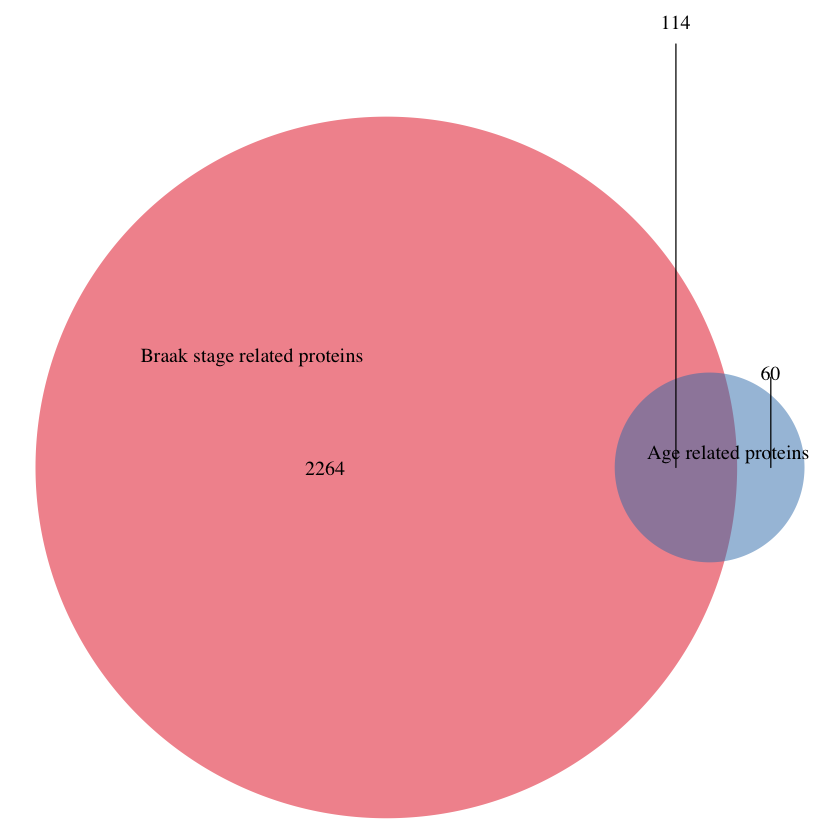

In [264]:
x <- list(Braak_sig = pathology_sig_index, 
          Age_sig = lm_index)

path <- "100_plus_plots/proteomics/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = NULL, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
             category.names=c("Braak stage related proteins","Age related proteins"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

In [265]:
pure_sig_age_index <- setdiff(lm_index, pathology_sig_index)
age_Braak_sig_idx <- setdiff(lm_index, pure_sig_age_index)

In [266]:
length(pure_sig_age_index)
length(age_Braak_sig_idx)

[1] 60

[1] 114

In [267]:
Age_related_proteins_lm

,effect_size,p_value,adjusted_p_value
,<dbl>,<dbl>,<dbl>
SLC12A2,-1.647547e-02,6.647424e-08,0.0002292032
CASKIN1,-3.661861e-04,7.673185e-01,1.0000000000
GNG2,5.278487e-03,3.431101e-02,1.0000000000
CARNS1,-3.059367e-02,1.316565e-05,0.0453951576
FH,5.221021e-03,1.773679e-01,1.0000000000
EFHD2,2.551017e-04,9.702510e-01,1.0000000000
PCLO,-3.476171e-03,3.428858e-01,1.0000000000
HSPA1A;HSPA1B,-7.918349e-04,6.260227e-01,1.0000000000
STIP1,1.457936e-02,8.936037e-02,1.0000000000


In [61]:
####################Write files into txt#################

In [62]:
Age_related_proteins <- protein_info

In [63]:
Age_related_proteins$slope <- Age_related_proteins_lm$effect_size
Age_related_proteins$p.value <- Age_related_proteins_lm$p_value
Age_related_proteins$FDR <- Age_related_proteins_lm$adjusted_p_value

In [64]:
Age_related_proteins

protein,uniprot_accessions,gene,HUGO_gene,slope,p.value,FDR
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,-1.647547e-02,6.647424e-08,0.0002292032
CASKIN1,Q8WXD9,CASKIN1,CASKIN1,-3.661861e-04,7.673185e-01,1.0000000000
GNG2,P59768;G3V3J9;G3V2N0,GNG2,GNG2,5.278487e-03,3.431101e-02,1.0000000000
CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,-3.059367e-02,1.316565e-05,0.0453951576
FH,P07954-2;P07954,FH,FH,5.221021e-03,1.773679e-01,1.0000000000
EFHD2,Q96C19;H0Y4Y4,EFHD2,EFHD2,2.551017e-04,9.702510e-01,1.0000000000
PCLO,Q9Y6V0-6;Q9Y6V0,PCLO,PCLO,-3.476171e-03,3.428858e-01,1.0000000000
HSPA1A;HSPA1B,P0DMV9;P0DMV8;A0A0G2JIW1;P0DMV8-2;V9GZ37,HSPA1A,HSPA1A,-7.918349e-04,6.260227e-01,1.0000000000
STIP1,P31948;P31948-2;P31948-3,STIP1,STIP1,1.457936e-02,8.936037e-02,1.0000000000


In [65]:
write.table(Age_related_proteins[pure_sig_age_index, ][, c(1, 3, 4, 5, 6, 7)], 
            "100_plus_results/Age_related_protein/Age_protein_pure_60.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [63]:
write.table(Age_related_proteins[age_Braak_sig_idx, ][, c(1, 3, 4, 5, 6, 7)], 
            "100_plus_results/Age_related_protein/Age&Braak_protein_114.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [45]:
write.table(cell_type_matrix[lm_index, ][, c(1, 2, 3, 5)], 
            "100_plus_results/Age_related_protein/Age_protein_174.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [45]:
write.table(cell_type_matrix[, c(1, 2, 3)], 
            "100_plus_results/background_proteins.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [38]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,apoe_OR,pmd_numeric,MMSE,age_level,MMSE_level
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,0.5,6.166667,21.00,3,1
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,1.0,5.283333,26.37,3,2
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,1.0,7.916667,26.78,3,2
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,1.0,5.916667,NA,2,NA
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,0.5,4.583333,NA,1,NA
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,3.2,5.500000,NA,1,NA
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,1.0,5.083333,NA,2,NA
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,5.5,2.000000,NA,2,NA
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,1.0,7.250000,NA,1,NA


#### Centenarian specific proteins

In [105]:
## CEN-ND specific proteins all Braak
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [58]:
## CEN-ND specific proteins w.r.t. MMSE 
test_abundance_for_aging_protective_proteins_wrtMMSE <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, (GROUP == "CHC")&(MMSE >= 26)))
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [30]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, braak < 4)
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [106]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, 
                                                test_abundance_for_aging_protective_proteins)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p.value")

aging_protective_test$FDR <- p.adjust(aging_protective_test$p.value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p.value, method = "bonferroni")

In [109]:
write.table(aging_protective_test, 
            file = "100_plus_results/Results_for_paper_supplementary/Age_proteins_to_CEN-Age_proteins_test.tsv", sep = '\t',
            col.names = TRUE, row.names = FALSE, quote = FALSE)

In [107]:
aging_protective_test$gene <- get_first_protein(aging_protective_test$protein)

In [108]:
length(which(aging_protective_test$FDR < 0.05))

[1] 108

In [54]:
all_CEN <- which(aging_protective_test$FDR < 0.05)

In [35]:
cen_sig_idx <- which(aging_protective_test$FDR < 0.05)

In [36]:
test_use_allBraak <- lm_index[which(aging_protective_test$FDR < 0.05)]

In [37]:
length(test_use_allBraak)

[1] 108

In [59]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, 
                                                test_abundance_for_aging_protective_proteins_wrtMMSE)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p.value")

aging_protective_test$FDR <- p.adjust(aging_protective_test$p.value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p.value, method = "bonferroni")

In [60]:
CEN_MMSE26 <- which(aging_protective_test$FDR < 0.05)

In [61]:
length(CEN_MMSE26)

[1] 109

In [57]:
CEN_MMSE26_ <- which(aging_protective_test$FDR < 0.05)

In [68]:
path <- "100_plus_plots/proteomics/overlap_aging_protein_with_diff_MMSE_cutoff.png"
p <- venn.diagram(list(A=all_CEN, 
                       B=CEN_MMSE26,
                       C=CEN_MMSE26_), filename = path, 
                  fill=c('#E41A1C',  '#4DAF4A', '#984EA3'),
             category.names=c("All centenarians", "Centenarian MMSE>=26", "Centenarian MMSE<26"), 
                  lwd = 0, alpha = 0.5, 
                  cat.dist=c(-0.1, -0.1, -0.1),
             width = 5, height = 5, units = 'in', res = 300)
#grid.draw(p)

In [69]:
length(all_CEN)
length(CEN_MMSE26)
length(CEN_MMSE26_)

[1] 108

[1] 109

[1] 106

In [74]:
dim(subset(metadata, (GROUP == "CHC")&(MMSE >= 26)))

[1] 17 18

In [75]:
dim(subset(metadata, (GROUP == "CHC")&(MMSE < 26)))

[1] 32 18

In [48]:
aging_protective_test_result <- cbind(Age_related_proteins_lm_result_sig[,c(1, 2, 3, 4, 9, 8 )], 
                                      aging_protective_test[, c(2:6)])

In [49]:
aging_protective_test_result

,protein,uniprot_accessions,gene,HUGO_gene,cell_type_marker,cluster,F.p,R_square,p.value,FDR,adj.p_value_B
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC12A2,SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,Oligodendrocytes,3,0.0014214835,0.16646322,5.332563e-02,7.930479e-02,1.000000e+00
CARNS1,CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,Oligodendrocytes,3,0.0055191600,0.12457819,3.204508e-05,1.429704e-04,5.575845e-03
MAP1B,MAP1B,P46821,MAP1B,MAP1B,,4,0.0987713985,0.03395283,2.443786e-03,6.158833e-03,4.252188e-01
SLC16A1,SLC16A1,P53985,SLC16A1,SLC16A1,,2,0.2197078735,0.01035305,9.366805e-01,9.580493e-01,1.000000e+00
IRGQ,IRGQ,Q8WZA9,IRGQ,IRGQ,,2,0.0006374232,0.19061836,9.396848e-04,2.771274e-03,1.635052e-01
MTHFD1,MTHFD1,P11586;F5H2F4,MTHFD1,MTHFD1,,1,0.0382257744,0.06351357,1.717462e-01,2.246905e-01,1.000000e+00
HSPA12A,HSPA12A,A0A1B0GTF3;O43301,HSPA12A,HSPA12A,,2,0.0013071125,0.16901244,4.200562e-02,6.584665e-02,1.000000e+00
FLOT1,FLOT1,O75955;A0A140T9R1;O75955-2;A2AB10;A0A140T9X0;A2AB09;A2AB12,FLOT1,FLOT1,,1,0.1048901189,0.03212063,7.637211e-01,8.076627e-01,1.000000e+00
KBTBD11,KBTBD11,O94819,KBTBD11,KBTBD11,,1,0.0205507590,0.08313496,8.762393e-02,1.210045e-01,1.000000e+00


In [55]:
aging_protective_test_sig108 <- aging_protective_test_result[which(aging_protective_test_result$FDR < 0.05), ]

In [51]:
table(aging_protective_test_sig108$cluster)


 1  2  3  4 
31 49 18 10 

In [245]:
age_diff$age_interval <- sapply(age_diff$end_age, function(x){
    return(paste(x-10, "-", x-1, sep=""))
})

In [250]:
colnames(age_diff) <- c("protein", "index", "end_age", "estimate_CHC_age", "CHC_age", "age_younger", "age_interval")

In [253]:
aging_protective_test_sig108 <- cbind(aging_protective_test_sig108, age_diff[c("age_interval", 
                                                                               "estimate_CHC_age", 
                                                                               "age_younger")])

In [254]:
write.table(aging_protective_test_sig108, 
            file = "100_plus_results/Sig_results_from_analysis/CEN-specific Age-related proteins (lm_t_test)-20220731.tsv", sep = '\t',
            col.names = TRUE, row.names = FALSE, quote = FALSE)

In [108]:
load(file = "Temp_results/Age_related_proteins_clust.Rdata")
protein_clust

protein,clust,gene,HUGO_gene,celltype
<fct>,<dbl>,<chr>,<chr>,<chr>
SLC12A2,3,SLC12A2,SLC12A2,Oligodendrocytes
CARNS1,3,CARNS1,CARNS1,Oligodendrocytes
MAP1B,4,MAP1B,MAP1B,NA
SLC16A1,2,SLC16A1,SLC16A1,NA
IRGQ,2,IRGQ,IRGQ,NA
MTHFD1,1,MTHFD1,MTHFD1,NA
HSPA12A,2,HSPA12A,HSPA12A,NA
FLOT1,1,FLOT1,FLOT1,NA
KBTBD11,1,KBTBD11,KBTBD11,NA


In [109]:
table(protein_clust$clust)


 1  2  3  4 
49 79 27 19 

In [110]:
protein_clust_CENT <- subset(protein_clust, protein %in% aging_protective_test_sig65$protein)

In [111]:
table(protein_clust_CENT$clust)


 1  2  3  4 
31 49 18 10 

In [112]:
protein_clust$inC2 <- 0
protein_clust[which(protein_clust$clust == 1), ]$inC2 <- 1

protein_clust$inCENT <- 0
protein_clust[which(protein_clust$protein %in% aging_protective_test_sig65$protein), ]$inCENT <- 1



table(protein_clust$inCENT)
table(protein_clust$inC2)

chisq.test(protein_clust$inCENT, protein_clust$inC2, correct=FALSE)


  0   1 
 66 108 


  0   1 
125  49 


	Pearson's Chi-squared test

data:  protein_clust$inCENT and protein_clust$inC2
X-squared = 0.041464, df = 1, p-value = 0.8386


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


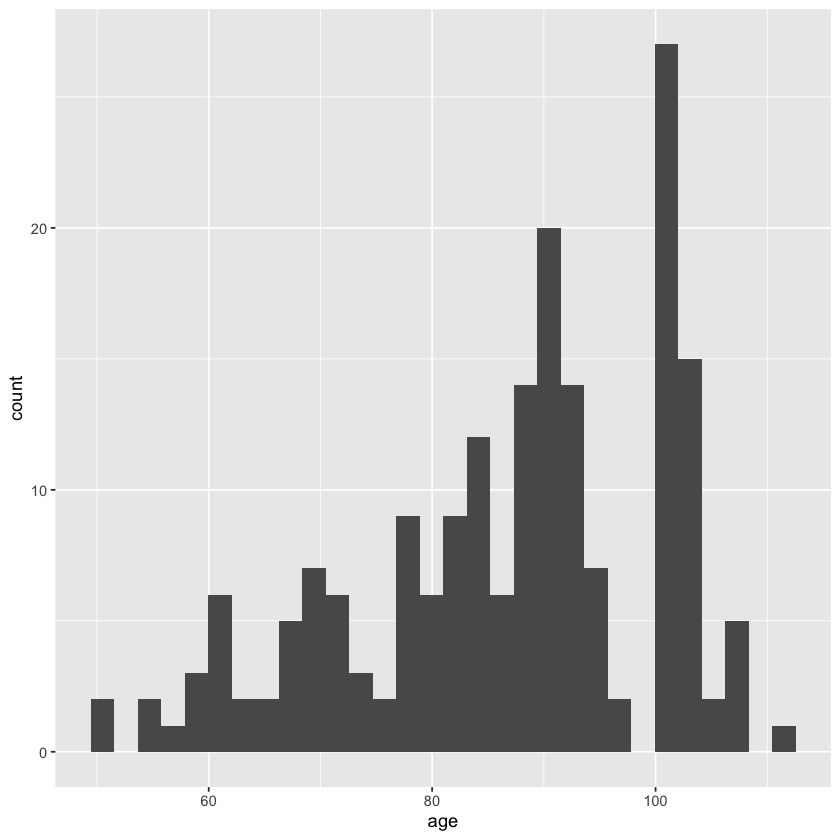

In [100]:
ggplot(metadata, aes(x = age, group = GROUP)) + geom_histogram(aes(group = GROUP))

In [103]:
test_KSD_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    CHC_idx <- which(protein_metadata$GROUP == "CHC")
    #print(length(CHC_idx))
    #print(table(protein_metadata$GROUP))
    KSD_age <- do.call(rbind, lapply(seq(100, 80, -1), function(age){
        idx_ND_in10y <- which((protein_metadata$age >= (age-10)) & (protein_metadata$age < age))
        KSD <- do.call(rbind, lapply(1:1000, function(i){
            idx_CHC_in10y <- sample(CHC_idx, size = length(idx_ND_in10y), replace = FALSE)
            dist <- as.numeric(ks.test(protein_metadata[idx_ND_in10y,]$intens, 
                                      protein_metadata[idx_CHC_in10y,]$intens, exact = FALSE)$statistic)
            mean_age <- mean(protein_metadata[idx_CHC_in10y,]$age)
            return(list(dist = dist, mean_age = mean_age))
        })) %>% apply(., 2, as.numeric) %>% as.data.frame(colnames = c("dist", "mean_age"))
        
        #print(class(KSD$dist))
        #print(head(KSD))
        return(list(age, mean(protein_metadata[idx_ND_in10y,]$age), mean(KSD$mean_age), sd(KSD$mean_age), 
                    mean(KSD$dist), sd(KSD$dist)))
    })) %>% apply(., 2, as.numeric) %>% as.data.frame()
    colnames(KSD_age) <-  c("age", "ND_age", "CHC_age", "CHC_age_sd", "mean_dist", "mean_dist_sd")
    KSD_age$protein <- rownames(protein_intensity_combat)[index]
    
    return(KSD_age)
}

In [104]:
res <- test_KSD_for_aging_protective_proteins(lm_index[1])

In [106]:
length(lm_index[cen_sig_idx])
length(lm_index[-cen_sig_idx])

[1] 108

[1] 66

In [107]:
KSD_age_per_protein <- lapply(lm_index[-cen_sig_idx], test_KSD_for_aging_protective_proteins)

In [108]:
KSD_age_per_protein[[1]]

age,ND_age,CHC_age,CHC_age_sd,mean_dist,mean_dist_sd,protein
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
100,92.17647,103.0442,0.4566872,0.2294118,0.06595734,SLC12A2
99,91.70000,103.0661,0.4035998,0.1793500,0.04861523,SLC12A2
98,91.70000,103.0593,0.3944605,0.1786000,0.05009540,SLC12A2
97,90.91667,103.0423,0.3297395,0.1756250,0.04220076,SLC12A2
96,90.69565,103.0483,0.3345903,0.1883913,0.04677235,SLC12A2
95,89.82609,103.0431,0.3378328,0.1932609,0.04751219,SLC12A2
94,89.58333,103.0398,0.3215969,0.2091250,0.04654536,SLC12A2
93,89.00000,103.0319,0.3358676,0.2363913,0.05454061,SLC12A2
92,87.55000,103.0261,0.3866824,0.2948500,0.07824385,SLC12A2


In [109]:
KSD_age_per_protein_all <- do.call(rbind, KSD_age_per_protein) %>% as.data.frame(stringsAsFactors = FALSE)

In [110]:
length(unique((KSD_age_per_protein_all$protein)))

[1] 66

In [111]:
setdiff(aging_protective_test_sig108$protein, unique((KSD_age_per_protein_all$protein)))

[1] "CARNS1"                             "MAP1B"                             
  [3] "IRGQ"                               "SHANK2"                            
  [5] "HADHA"                              "RPS6KA2;RPS6KA3"                   
  [7] "CIT"                                "RPS3"                              
  [9] "TPD52L1"                            "RALA"                              
 [11] "NEFM"                               "PTGES2"                            
 [13] "RRAGC;RRAGD"                        "CNP"                               
 [15] "GSTK1"                              "PDPK1;PDPK2P"                      
 [17] "ANXA11"                             "CACNA1E"                           
 [19] "RPSA"                               "DYNC1I1"                           
 [21] "CCT3"                               "SCN2A"                             
 [23] "INA"                                "ALCAM"                             
 [25] "NCDN"                               "CCT6A"                             
 [27] "SNX9"                               "TUBB3;TUBB4A;TUBB4B"               
 [29] "TUBB"                               "MOG"                               
 [31] "H1FX"                               "NEFL"                              
 [33] "PNMA8B"                             "RAB11A;RAB11B"                     
 [35] "CNTN1"                              "CSDE1"                             
 [37] "STX5"                               "MAP1A;MAP1B"                       
 [39] "TUBB4A;TUBB4B;TUBB8"                "AK3"                               
 [41] "AMPD2"                              "SIRT2"                             
 [43] "SLC44A1"                            "CD9"                               
 [45] "PLEKHB1"                            "C2;CFB"                            
 [47] "RPS16"                              "PTK2B"                             
 [49] "LRRC4B"                             "USP7"                              
 [51] "GNA13"                              "MAG"                               
 [53] "PIP4K2A;PIP4K2B"                    "PDIA6"                             
 [55] "TPBG"                               "NDUFAF4"                           
 [57] "PDE1A;PDE1C"                        "ABLIM1"                            
 [59] "MCAM"                               "PNCK"                              
 [61] "CSNK2A1;CSNK2A3"                    "AP3B1"                             
 [63] "RPS6KA2"                            "USP11"                             
 [65] "IGSF21"                             "TUBB4A"                            
 [67] "PSD3"                               "SHMT2"                             
 [69] "CDK1"                               "LZTS1"                             
 [71] "GGA3"                               "NUMA1"                             
 [73] "LGALS3BP"                           "OGFRL1"                            
 [75] "SNX5"                               "RHOG"                              
 [77] "TUBB3;TUBB6"                        "PON2"                              
 [79] "INA;NEFH;NEFL;NEFM;VIM"             "PCSK1"                             
 [81] "MAP3K5"                             "ENPP6"                             
 [83] "RIMBP2"                             "UBAP2L"                            
 [85] "CCT6B"                              "FAM169A"                           
 [87] "NAP1L1"                             "RPS13"                             
 [89] "RUFY3"                              "SSB"                               
 [91] "DIP2A;DIP2C"                        "GLTP"                              
 [93] "ILF2"                               "RAP1A;RAP1B"                       
 [95] "WASH2P;WASH3P;WASH4P;WASH6P;WASHC1" "CAND1;CAND2"                       
 [97] "ITGB4"                              "ANLN"                              
 [99] "RPL31"                              "WRN"                               
[1

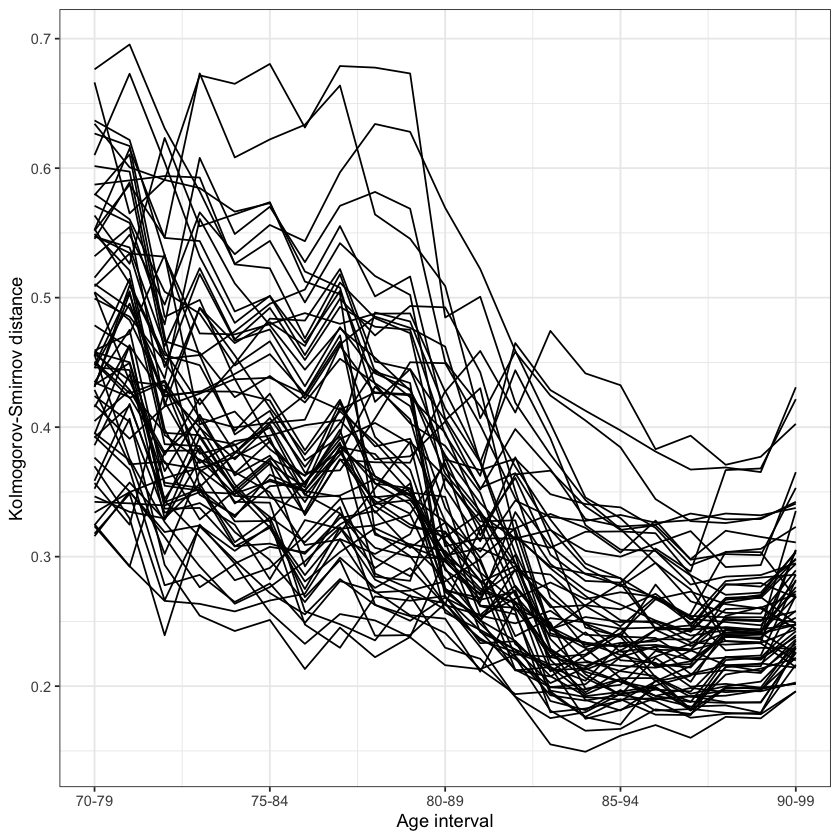

In [112]:
ggplot(KSD_age_per_protein_all, aes(x = as.numeric(age), y = as.numeric(mean_dist), group = as.factor(protein))) + 
    geom_line() +
    scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
                                                                 "75-84",
                                                                 "80-89",
                                                                 "85-94",
                                                                 "90-99")) +
    xlab("Age interval") + 
    ylab("Kolmogorov-Smirnov distance") +
    theme_bw()

In [113]:
protein <- NULL
idx <- NULL
mean_age <- NULL
mean_age_ND <- NULL
mean_age_CHC <- NULL

In [114]:
for(i in 1:length(KSD_age_per_protein)){
    temp_df <- as.data.frame(KSD_age_per_protein[[i]], stringsAsFactors = FALSE)
    protein <- c(protein, unique(temp_df$protein))
    min_idx <- which.min(as.numeric(temp_df$mean_dist))
    idx <- c(idx, min_idx)
    mean_age <- c(mean_age, as.numeric(temp_df[min_idx, ]$age))
    mean_age_ND <- c(mean_age_ND, as.numeric(temp_df[min_idx, ]$ND_age))
    mean_age_CHC <- c(mean_age_CHC, as.numeric(temp_df[min_idx, ]$CHC_age))
}

In [115]:
age_diff <- data.frame(protein = protein, index = idx, end_age = mean_age, ND_age = mean_age_ND, CHC_age = mean_age_CHC)

In [116]:
age_diff$younger <- age_diff$CHC_age - age_diff$ND_age

In [117]:
summary(age_diff$younger)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.85   12.12   12.34   13.24   13.46   23.85 

In [118]:
mean(age_diff$end_age)
sd(age_diff$end_age)

[1] 95.33333

[1] 3.00427

In [119]:
age_diff

protein,index,end_age,ND_age,CHC_age,younger
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
SLC12A2,4,97,90.91667,103.0423,12.12562
SLC16A1,4,97,90.91667,103.0453,12.12867
MTHFD1,6,95,89.82609,103.0354,13.20935
HSPA12A,7,94,89.58333,103.0415,13.45813
FLOT1,1,100,92.17647,103.0306,10.85412
KBTBD11,4,97,90.91667,103.0272,12.11058
ATP1A2,10,91,85.76471,103.0104,17.24565
AMPH,3,98,91.70000,103.0343,11.33430
ATP1A1;ATP1A3,6,95,89.82609,103.0423,13.21617


In [120]:
table(idx)
table(mean_age)

idx
 1  2  3  4  5  6  7  8  9 10 11 15 17 
 1  6  7 17  5  6  9  7  1  4  1  1  1 

mean_age
 84  86  90  91  92  93  94  95  96  97  98  99 100 
  1   1   1   4   1   7   9   6   5  17   7   6   1 

In [121]:
table(idx)
table(mean_age)

idx
 1  2  3  4  5  6  7  8  9 10 11 15 17 
 1  6  7 17  5  6  9  7  1  4  1  1  1 

mean_age
 84  86  90  91  92  93  94  95  96  97  98  99 100 
  1   1   1   4   1   7   9   6   5  17   7   6   1 

In [122]:
mean(mean_age)
sd(mean_age)

[1] 95.33333

[1] 3.00427

In [54]:
length(lm_index[cen_sig_idx])

[1] 108

In [55]:
protein_intensity_combat[test_use_allBraak, ][, c(index_ND, index_CHC)]

,intensity_20190325_194_S02_055_ND_005,intensity_20190325_77_S11_072_ND_012,intensity_20190325_79_S07_308_ND_009,intensity_20190325_95_S05_217_ND_002,intensity_20190326_195_S03_035_ND_024,intensity_20190326_201_S08_325_ND_019,intensity_20190326_203_S09_067_ND_016,intensity_20190326_220_SVU10_277_ND_022,intensity_20190328_100_S14_051_ND_032,intensity_20190328_108_NABCA15_08_ND_028,⋯,intensity_20190502_118_S15_090_CHC_181,intensity_20190502_122.S16_026_CHC_199,intensity_20190502_155_2018_011_CHC_183,intensity_20190502_161_2018_043_CHC_197,intensity_20190502_166_2018_083_CHC_193,intensity_20190507_112_S14_037_CHC_215,intensity_20190507_142_2017_046_CHC_220,intensity_20190507_148_2017_104_CHC_208,intensity_20190507_164_2018_065_CHC_212,intensity_20190606_140_2017_027_CHC_RERUN
CARNS1,6.893927,5.513223,6.432737,6.556345,7.982972,5.859078,7.282004,7.389821,5.457597,7.195790,⋯,5.272469,5.042286,7.189964,6.436861,7.375407,6.457987,6.790715,7.262049,6.695807,7.206671
MAP1B,14.047438,13.327504,13.669150,13.628169,14.203915,13.795312,14.102194,13.462826,13.721036,14.115268,⋯,13.695368,13.615955,14.117709,13.843077,14.286139,13.438146,13.992985,13.984696,13.931767,13.891791
IRGQ,8.723143,8.661529,8.562611,8.757914,8.823384,8.175201,8.725143,8.838027,8.688376,8.995842,⋯,8.179430,8.249036,8.781966,8.399641,8.902299,8.032178,8.733930,8.389661,8.146557,8.646515
SHANK2,8.611868,7.780354,7.816888,8.190099,7.563417,8.230153,8.343019,8.077055,8.187728,8.410823,⋯,7.786956,7.931071,8.146635,7.829209,8.215198,7.585110,8.050809,7.586228,8.284454,8.119638
HADHA,11.993591,11.678639,12.017937,11.792044,11.902925,12.127177,12.004626,12.313750,11.880877,11.871147,⋯,12.041087,11.770097,11.784365,12.093532,11.998813,11.938915,11.738929,12.090586,11.920830,11.982294
RPS6KA2;RPS6KA3,7.227122,7.328302,7.324754,7.643302,7.505389,7.831331,7.767834,7.686237,7.412453,7.440442,⋯,7.708050,7.516788,7.405553,7.364294,7.716154,7.656711,7.166081,7.743590,8.022349,7.626518
CIT,10.095150,10.210954,9.767791,10.208380,9.773554,10.291619,9.906483,9.792646,10.222844,9.894043,⋯,10.302762,10.146686,9.617969,10.095800,9.879799,10.077572,9.546724,9.769745,10.295525,9.425165
RPS3,12.444242,12.351000,12.353954,12.376079,12.388445,12.470849,12.402103,12.410751,12.282422,12.310704,⋯,12.485102,12.430934,12.501162,12.409305,12.664651,12.228242,12.226650,12.416206,12.391021,12.520220
TPD52L1,6.197189,6.379822,6.946652,6.569217,6.463935,7.116704,6.613561,5.488616,6.393778,6.743315,⋯,7.059185,6.257545,6.398423,6.372060,6.345115,6.555261,6.392853,6.459023,6.652644,6.384342
RALA,10.521415,10.375603,10.778957,10.499255,10.529321,10.560448,10.626559,10.856142,10.514572,10.713057,⋯,10.671596,10.588461,10.634946,10.683575,10.637883,10.604316,10.533807,10.746591,10.697159,10.588011


In [85]:
cen_specific_protein108_scale <- t(scale(t(protein_intensity_combat[test_use_allBraak, ][, index_CHC]), center = TRUE, scale = TRUE))

In [57]:
cen_specific_protein108_scale <- protein_intensity_combat[test_use_allBraak, ][, c(index_ND, index_CHC)]

In [71]:
cen_specific_protein108_scale

,intensity_20190325_194_S02_055_ND_005,intensity_20190325_77_S11_072_ND_012,intensity_20190325_79_S07_308_ND_009,intensity_20190325_95_S05_217_ND_002,intensity_20190326_195_S03_035_ND_024,intensity_20190326_201_S08_325_ND_019,intensity_20190326_203_S09_067_ND_016,intensity_20190326_220_SVU10_277_ND_022,intensity_20190328_100_S14_051_ND_032,intensity_20190328_108_NABCA15_08_ND_028,⋯,intensity_20190502_118_S15_090_CHC_181,intensity_20190502_122.S16_026_CHC_199,intensity_20190502_155_2018_011_CHC_183,intensity_20190502_161_2018_043_CHC_197,intensity_20190502_166_2018_083_CHC_193,intensity_20190507_112_S14_037_CHC_215,intensity_20190507_142_2017_046_CHC_220,intensity_20190507_148_2017_104_CHC_208,intensity_20190507_164_2018_065_CHC_212,intensity_20190606_140_2017_027_CHC_RERUN
CARNS1,6.893927,5.513223,6.432737,6.556345,7.982972,5.859078,7.282004,7.389821,5.457597,7.195790,⋯,5.272469,5.042286,7.189964,6.436861,7.375407,6.457987,6.790715,7.262049,6.695807,7.206671
MAP1B,14.047438,13.327504,13.669150,13.628169,14.203915,13.795312,14.102194,13.462826,13.721036,14.115268,⋯,13.695368,13.615955,14.117709,13.843077,14.286139,13.438146,13.992985,13.984696,13.931767,13.891791
IRGQ,8.723143,8.661529,8.562611,8.757914,8.823384,8.175201,8.725143,8.838027,8.688376,8.995842,⋯,8.179430,8.249036,8.781966,8.399641,8.902299,8.032178,8.733930,8.389661,8.146557,8.646515
SHANK2,8.611868,7.780354,7.816888,8.190099,7.563417,8.230153,8.343019,8.077055,8.187728,8.410823,⋯,7.786956,7.931071,8.146635,7.829209,8.215198,7.585110,8.050809,7.586228,8.284454,8.119638
HADHA,11.993591,11.678639,12.017937,11.792044,11.902925,12.127177,12.004626,12.313750,11.880877,11.871147,⋯,12.041087,11.770097,11.784365,12.093532,11.998813,11.938915,11.738929,12.090586,11.920830,11.982294
RPS6KA2;RPS6KA3,7.227122,7.328302,7.324754,7.643302,7.505389,7.831331,7.767834,7.686237,7.412453,7.440442,⋯,7.708050,7.516788,7.405553,7.364294,7.716154,7.656711,7.166081,7.743590,8.022349,7.626518
CIT,10.095150,10.210954,9.767791,10.208380,9.773554,10.291619,9.906483,9.792646,10.222844,9.894043,⋯,10.302762,10.146686,9.617969,10.095800,9.879799,10.077572,9.546724,9.769745,10.295525,9.425165
RPS3,12.444242,12.351000,12.353954,12.376079,12.388445,12.470849,12.402103,12.410751,12.282422,12.310704,⋯,12.485102,12.430934,12.501162,12.409305,12.664651,12.228242,12.226650,12.416206,12.391021,12.520220
TPD52L1,6.197189,6.379822,6.946652,6.569217,6.463935,7.116704,6.613561,5.488616,6.393778,6.743315,⋯,7.059185,6.257545,6.398423,6.372060,6.345115,6.555261,6.392853,6.459023,6.652644,6.384342
RALA,10.521415,10.375603,10.778957,10.499255,10.529321,10.560448,10.626559,10.856142,10.514572,10.713057,⋯,10.671596,10.588461,10.634946,10.683575,10.637883,10.604316,10.533807,10.746591,10.697159,10.588011


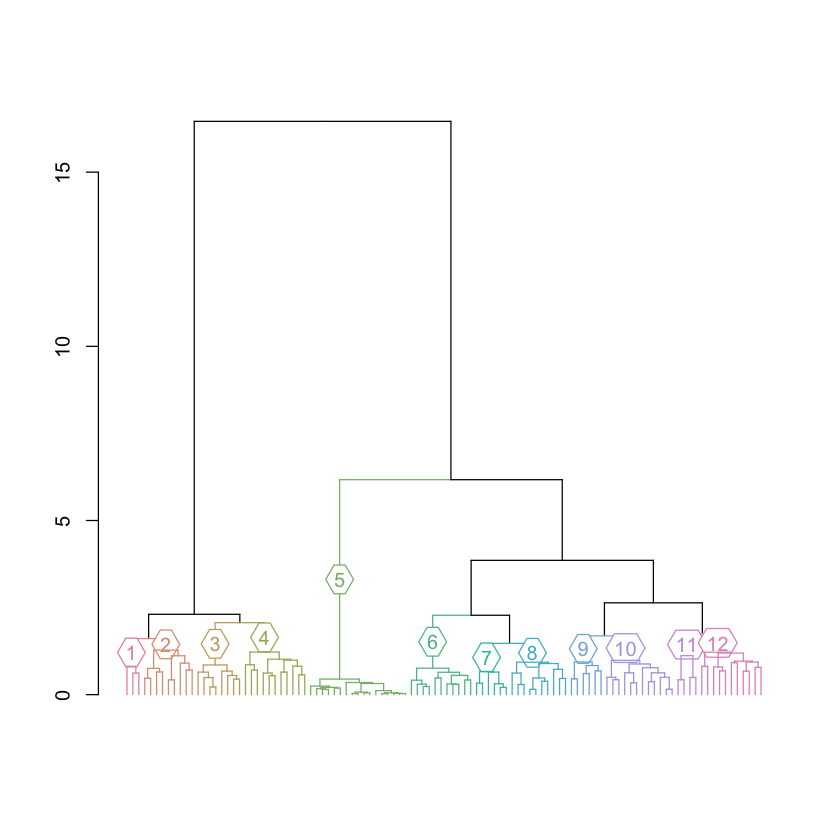

In [119]:
hc <- hclust(amap:::Dist(cen_specific_protein108_scale, 
                         method = "correlation"), method = "ward.D")
c_group <- 12 # number of clusters
dend1 <- as.dendrogram(hc)

#protein_clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = TRUE)
clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)
#clust <- dynamicTreeCut:::cutreeDynamic(hc, distM = distMa, method = "tree")
#c_group <- max(clust) 

orig_label <- labels(dend1)

plot_labels <- clust

lbls <- unique(clust)
labels(dend1) <- plot_labels

dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

# get the color of the leaves (labels) for `heatmap.2`
col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]

plot_labels <- plot_labels[order(order.dendrogram(dend1))]

dend1 <- set(dend1, "labels_cex", 0.8)

#pdf("Temp_results/protein_clustering_dendrogram.pdf")
#par(mar=c(1, 3, 1, 1))
plot(dend1, #ylim = c(0,10), 
     leaflab = "none") # use side = T to horiz mirror if needed
#dev.off()

In [120]:
clust

ABLIM1                        PDE1A;PDE1C 
                                 1                                  1 
                     DNAJB1;DNAJB4                               H1FX 
                                 1                                  2 
                              ILF2                            FAM169A 
                                 2                                  2 
                               SSB                    RPS6KA2;RPS6KA3 
                                 2                                  2 
                           RPS6KA2                               USP7 
                                 2                                  2 
                             NUMA1                              ITGB4 
                                 2                                  2 
                             USP11                              PTK2B 
                                 3                                  3 
                               CIT                              LZTS1 
                                 3                                  3 
                              PSD3                       PDPK1;PDPK2P 
                                 3                                  3 
                              NCDN                              AMPD2 
                                 3                                  3 
                            OGFRL1                        RRAGC;RRAGD 
                                 4                                  4 
                            MAP3K5                             RIMBP2 
                                 4                                  4 
                           TPD52L1                              PCSK1 
                                 4                                  4 
                            PTGES2                            CACNA1E 
                                 4                                  4 
                              GGA3                               SNX5 
                                 4                                  4 
                    NCKAP1;NCKAP1L                              ENPP6 
                                 4                                  5 
                            CARNS1                               RHOG 
                                 5                                  5 
                              ANLN                           LGALS3BP 
                                 5                                  5 
                              GLTP                               MCAM 
                                 5                                  5 
                              NEFM                               NEFL 
                                 5                                  5 
                               INA             INA;NEFH;NEFL;NEFM;VIM 
                                 5                                  5 
                           SLC44A1                                CNP 
                                 5                                  5 
                               CD9                                MOG 
                                 5                                  5 
                             SIRT2                                MAG 
                                 5                                  5 
               TUBB3;TUBB4A;TUBB4B                             TUBB4A 
                                 6                                  6 
                              TUBB                TUBB4A;TUBB4B;TUBB8 
                                 6                                  6 
                       TUBB3;TUBB6                             NAP1L1 
                                 6                                  6 
                             RUFY3                               RPS3 
                                 6                                  6 
                             CCT6B                  

In [121]:
table(clust)

clust
 1  2  3  4  5  6  7  8  9 10 11 12 
 3  9  8 11 17 11  6 10  6 12  4 11 

In [122]:
map_cluster_to_protein <- function(clust, proteins){
    new_cluster <- as.numeric(lapply(proteins, function(x){return(clust[which(names(clust) == x)])}))
    return(data.frame(protein = proteins,
                      clust = new_cluster))
}

In [123]:
protein_clust <- map_cluster_to_protein(clust, rownames(protein_intensity_combat[test_use_allBraak, ]))

In [124]:
protein_clust$gene <- cell_type_matrix[lm_index[cen_sig_idx], ]$genesymbol
protein_clust$HUGO_gene <- cell_type_matrix[lm_index[cen_sig_idx], ]$HUGO_gene
protein_clust$celltype <- cell_type_matrix[lm_index[cen_sig_idx], ]$celltype

In [125]:
protein_clust

protein,clust,gene,HUGO_gene,celltype
<fct>,<dbl>,<chr>,<chr>,<chr>
CARNS1,5,CARNS1,CARNS1,Oligodendrocytes
MAP1B,8,MAP1B,MAP1B,NA
IRGQ,8,IRGQ,IRGQ,NA
SHANK2,8,SHANK2,SHANK2,NA
HADHA,10,HADHA,HADHA,NA
RPS6KA2;RPS6KA3,2,RPS6KA2,RPS6KA2,NA
CIT,3,CIT,CIT,NA
RPS3,6,RPS3,RPS3,NA
TPD52L1,4,TPD52L1,TPD52L1,Astrocytes


In [85]:
write.table(protein_clust[order(protein_clust$clust), ], 
            file = "100_plus_results/Sig_results_from_analysis/CEN-specific Age-related proteins (8clusters).tsv", 
            sep = '\t',
            col.names = TRUE, row.names = FALSE, quote = FALSE)

In [126]:
save(protein_clust, 
     file = "100_plus_results/Sig_results_from_analysis/CEN-specific_Age-related_proteins_in_8clusters.Rdata")

In [290]:
for(i in 1:c_group){
    
    protein_list <- as.character(unique(subset(protein_clust, clust == i)$gene))
    
    cat("this is cluster", i, end = "\n")
    print(length(protein_list))
    
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
        names(geneList) <- backgroud_protein_list
    
    sigGOID <- NULL
    
    sigRes_BP <- GOterm_query_test_table(protein_list, geneList, "BP")
    print(sigRes_BP)
        
    #sigRes_MF <- GOterm_query_test_table(protein_list, geneList, "MF")
    #print(sigRes_MF)
    #    
    #sigRes_CC <- GOterm_query_test_table(protein_list, geneList, "CC")
    #print(sigRes_CC)
}

this is cluster 1 
[1] 18



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1225 nontrivial nodes
		 parameters: 
			 test statistic: fisher


       GO.ID                                                 Term Annotated
1 GO:0010660          regulation of muscle cell apoptotic process        15
2 GO:0010657                        muscle cell apoptotic process        16
3 GO:0010656 negative regulation of muscle cell apoptotic process         5
  Significant Expected  Fisher       FDR            proteins
1           3     0.09 8.3e-05 0.1796000 PDE1A, PDPK1, PTK2B
2           3     0.10 1.0e-04 0.1796000 PDE1A, PDPK1, PTK2B
3           2     0.03 3.5e-04 0.4190667        PDPK1, PTK2B
this is cluster 2 
[1] 16



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 766 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
this is cluster 3 
[1] 15



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1075 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
this is cluster 4 
[1] 21



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1154 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                            Term Annotated
1  GO:0031099                                    regeneration        48
2  GO:0045103             intermediate filament-based process        16
3  GO:0045104 intermediate filament cytoskeleton organization        16
4  GO:0031103                               axon regeneration        19
5  GO:0031102                  neuron projection regeneration        21
6  GO:0007096                 regulation of exit from mitosis         5
7  GO:0060052         neurofilament cytoskeleton organization         5
8  GO:0045109              intermediate filament organization         6
9  GO:0048678                         response to axon injury        26
10 GO:0021762                    substantia nigra development        27
13 GO:0048709                 oligodendrocyte differentiation        28
14 GO:0048857                      neural nucleus development        28
15 GO:0017085                         response to insecticide   


Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 357 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
this is cluster 6 
[1] 29



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1053 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"


In [52]:
protein_list <- as.character(unique(aging_protective_test_result$gene))

In [58]:
protein_list <- as.character(unique(aging_protective_test_sig108$gene))
    
#cat("this is cluster", i, end = "\n")
print(length(protein_list))

geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list

sigGOID <- NULL

sigRes_BP <- GOterm_query_test_table(protein_list, geneList, "MF")
print(sigRes_BP)

[1] 103



Building most specific GOs .....
	( 2025 GO terms found. )

Build GO DAG topology ..........
	( 2521 GO terms and 3271 relations. )

Annotating nodes ...............
	( 2930 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 324 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"


In [13]:
aging_protective_test_sig108 <- read.table(file = "100_plus_results/Sig_results_from_analysis/CEN-specific Age-related proteins (lm_t_test)-20220731.tsv", 
                                           sep = '\t', head = TRUE)

In [14]:
aging_protective_test_sig108

protein,uniprot_accessions,gene,HUGO_gene,cell_type_marker,cluster,F.p,R_square,p.value,FDR,adj.p_value_B,age_interval,estimate_CHC_age,age_younger
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,Oligodendrocytes,3,0.0055191600,0.12457819,3.204508e-05,1.429704e-04,5.575845e-03,83-92,89.00000,14.05865
MAP1B,P46821,MAP1B,MAP1B,,4,0.0987713985,0.03395283,2.443786e-03,6.158833e-03,4.252188e-01,82-91,87.55000,15.48975
IRGQ,Q8WZA9,IRGQ,IRGQ,,2,0.0006374232,0.19061836,9.396848e-04,2.771274e-03,1.635052e-01,82-91,87.55000,15.47230
SHANK2,E7EUA2;Q9UPX8-4;A6NHU9;A0A0A0MSQ6;Q9UPX8;Q9UPX8-3;H7C1X5,SHANK2,SHANK2,,2,0.0156901079,0.09167664,2.686351e-02,4.485587e-02,1.000000e+00,87-96,90.91667,12.12958
HADHA,P40939,HADHA,HADHA,,2,0.0485374849,0.05599918,4.015698e-03,8.844702e-03,6.987314e-01,83-92,89.00000,14.03548
RPS6KA2;RPS6KA3,F2Z2J1;Q15349-2;Q15349-3;Q15349;B7Z3B5;P51812,RPS6KA2,RPS6KA2,,1,0.0033455204,0.14016940,2.477691e-03,6.158833e-03,4.311183e-01,84-93,89.58333,13.47733
CIT,O14578-3;H7BYJ3;O14578;O14578-4,CIT,CIT,,1,0.0034836056,0.13891507,1.499490e-06,1.534773e-05,2.609113e-04,70-79,75.00000,28.02754
RPS3,P23396;P23396-2;E9PPU1;E9PL09;F2Z2S8;H0YCJ7;H0YF32;H0YEU2,RPS3,RPS3,,2,0.0483930849,0.05609271,2.822497e-03,6.821034e-03,4.911144e-01,70-79,75.00000,28.01838
TPD52L1,Q16890-4;Q16890-3;Q16890-2;E9PNK6;Q16890-5;E9PPQ1;Q16890;J3KNE7;E9PNQ9,TPD52L1,TPD52L1,Astrocytes,1,0.0016591379,0.16175139,4.145861e-08,1.528898e-06,7.213798e-06,82-91,87.55000,15.49825


In [15]:
cellsenescence_gene  <- read.table(file = "100_plus_results/Sig_results_from_analysis/cellAge1.csv", 
                                           sep = ';', head = TRUE)

In [16]:
cellsenescence_gene

hagrid,gene_name,hgncid,entrezid,organism,cancer_type,senescence_effect,description,notes
<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,ACLY,115,47,Human,No,Inhibits,"ACLY knockdown in primary human cells triggered cellular senescence and activation of tumor suppressor p53. Provision of acetyl CoA to ACLY knockdown cells did not alleviate ACLY silencing-induced p53 activation, suggesting an independent role for ACLY activity.","The primary HDF cells, HEK293T and HCT116 cells"
2,AAK1,19679,22848,Human,No,Induces,"A library of 200 constitutively activated kinases was screened in order to identify kinases whose constitutive expression decreased cell proliferation and induced expression of senescence markers; p16 and SASP components. A total of 33 kinases showed pro-senescence effects (particularly MAP3K7, PRKCD, and MATK); kinases with strong pro-senescence effects, induced expression of SASP-component genes (e.g. IL1A, IL1B, IL6 and IL8) through activation of an NF-kappaB-dependent transcriptional program. Inhibition of the NF-kappaB, p53, or Rb pathway proved insufficient to prevent kinase-triggered cell cycle arrest.","IMR-90, MRC-5, and GP293 cells"
3,ABI3,29859,51225,Human,Yes,Induces,"Ectopic expression of ABI3 lowered transforming activity, reduced in vitro tumor growth properties, suppressed in vitro anchorage-independent growth and in vivo tumor formation, whilst also increasing cellular senescence. These responses were accompanied by upregulation of cell cycle inhibitor p21 and reduced ERK phosphorylation and E2F1 expression.",A follicular thyroid carcinoma cell line (WRO) and a colon cancer-derived HT-29 cell line (ARO)
4,ADCK5,21738,203054,Human,No,Induces,"A library of 200 constitutively activated kinases was screened in order to identify kinases whose constitutive expression decreased cell proliferation and induced expression of senescence markers; p16 and SASP components. A total of 33 kinases showed pro-senescence effects (particularly MAP3K7, PRKCD, and MATK); kinases with strong pro-senescence effects, induced expression of SASP-component genes (e.g. IL1A, IL1B, IL6 and IL8) through activation of an NF-kappaB-dependent transcriptional program. Inhibition of the NF-kappaB, p53, or Rb pathway proved insufficient to prevent kinase-triggered cell cycle arrest.","IMR-90, MRC-5 , and GP293 cells"
5,AKR1B1,381,231,Human,Yes,Inhibits,"Overexpression of aldose reductase (AKR1B1) in HaCaT cells attenuated UVB-induced cellular damage and apoptosis, with a decreased generation of reactive oxygen species (ROS) and aldehydes - RNA interference or inhibition of aldose reductase abolished these effects.",HaCaT cells
6,AGT,333,183,Human,No,Induces,Treatment with Ang II (AGT) of vascular smooth muscle cells significantly induced premature senescence (including increased SA-beta galactosidase activity) via the p53/p21-dependent pathway.,
7,AKT1,391,207,Human,No,Induces,"Expression of constitutively activated AKT1 in endothelial cells promoted senescence-like growth arrest with the cells displaying enlarged, flattened morphology and increased SA-beta-galactosidase activity. This senescence effect was dependent on the p53/p21 pathway.",
8,ALOX15B,434,247,Human,No,Induces,Expression of 15-LOX2 (ALOX15B) or its splice variants drove a fraction of young normal human prostate cells to cell-cycle arrest and cell senescence.,
9,AR,644,367,Human,No,Induces,"Overexpression of the androgen receptor (AR) promoted androgen-induced premature senescence in association with p16 upregulation, whereas AR knockdown diminished the effects of androgen.",Primary human hair follicular keratynocites


In [17]:
aging_protective_test_sig108[which(aging_protective_test_sig108$gene %in% cellsenescence_gene$gene_name), ]

,protein,uniprot_accessions,gene,HUGO_gene,cell_type_marker,cluster,F.p,R_square,p.value,FDR,adj.p_value_B,age_interval,estimate_CHC_age,age_younger
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
16,PDPK1;PDPK2P,E9PER6;O15530;O15530-3;O15530-5;O15530-4;O15530-2;Q6A1A2,PDPK1,PDPK1,,1,0.009845087,0.10639910,1.455070e-03,4.219704e-03,2.531822e-01,83-92,89.00000,14.04870
61,CSNK2A1;CSNK2A3,E7EU96;P68400;Q8NEV1;P68400-2,CSNK2A1,CSNK2A1,,2,0.004934110,0.12808005,9.017765e-06,5.230304e-05,1.569091e-03,85-94,89.82609,13.21939
69,CDK1,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,CDK1,CDK1,,2,0.047316448,0.05679919,1.477608e-07,2.769332e-06,2.571037e-05,77-86,80.80000,22.26393
97,ITGB4,P16144-4;P16144-2;P16144-3;P16144,ITGB4,ITGB4,Astrocytes,1,0.012769404,0.09818979,4.720959e-06,3.159411e-05,8.214469e-04,90-99,92.17647,10.83588
100,WRN,Q14191,WRN,WRN,,2,0.023353968,0.07908709,1.627231e-03,4.494258e-03,2.831383e-01,85-94,89.82609,13.21170


In [269]:
load(file = "Temp_results/CEN_specific_Age_idx.Rdata")

In [271]:
length(CEN_ND_idx_old)

[1] 97

In [274]:
length(setdiff(cen_sig_idx, CEN_ND_idx_old))

[1] 13

In [277]:
aging_protective_test[setdiff(cen_sig_idx, CEN_ND_idx_old), ]

write.table(aging_protective_test[setdiff(cen_sig_idx, CEN_ND_idx_old), ], 
            file = "Temp_results/Centenarian_specific_Age_related_proteins_updatedBraak_13_extra.tsv", sep = '\t',
            col.names = TRUE, row.names = FALSE, quote = FALSE)

,protein,F.p,R_square,p.value,FDR,adj.p_value_B,gene
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
17,RPS3,0.0483930849,0.05609271,0.002822497,0.006821034,0.4911144,RPS3
32,RPSA,0.0180929359,0.08716725,0.026644778,0.044855867,1.0000000,RPSA
38,ALCAM,0.0005632993,0.19429668,0.008495517,0.016797954,1.0000000,ALCAM
59,CSDE1,0.0016042275,0.16277862,0.003705583,0.008373655,0.6447714,CSDE1
82,RPS16,0.0420339418,0.06052168,0.015341614,0.027520009,1.0000000,RPS16
84,LRRC4B,0.0075812355,0.11462422,0.001782723,0.004723610,0.3101939,LRRC4B
90,GNA13,0.0088515915,0.10975068,0.003990929,0.008844702,0.6944216,GNA13
95,TPBG,0.0277623635,0.07361554,0.027068196,0.044855867,1.0000000,TPBG
103,AP3B1,0.0414670393,0.06094918,0.010026390,0.019384355,1.0000000,AP3B1


In [276]:
aging_protective_test[setdiff(CEN_ND_idx_old, cen_sig_idx), ]

,protein,F.p,R_square,p.value,FDR,adj.p_value_B,gene
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,TMEM30A,0.07650659,0.04180719,0.07438850,0.10609507,1,TMEM30A
151,ELAVL2,0.02537081,0.07646552,0.03436172,0.05485265,1,ELAVL2


In [36]:
CEN_ND_idx_AllBraak_11 <- which(aging_protective_test$FDR < 0.05)

In [37]:
length(lm_index)

[1] 174

In [94]:
load(file = "CEN_specific_Age_idx.Rdata")

In [95]:
length(lm_index[CEN_ND_idx_old])

[1] 97

In [275]:
Age_related_proteins$is_Age_related <- ""
Age_related_proteins[lm_index, ]$is_Age_related <- "Yes"

In [276]:
Age_related_proteins$Age_pure <- ""
Age_related_proteins[pure_sig_age_index, ]$Age_pure <- "Yes"

In [277]:
Age_related_proteins$Age_Braak <- ""
Age_related_proteins[age_Braak_sig_idx, ]$Age_Braak <- "Yes"

In [278]:
Age_related_proteins$CEN_specific_ALL_centenarians <- ""
Age_related_proteins[test_use_allBraak, ]$CEN_specific_ALL_centenarians <- "Yes"

In [279]:
Age_related_proteins$CEN_specific_Braak1to3_old <- ""
Age_related_proteins[lm_index[CEN_ND_idx_old], ]$CEN_specific_Braak1to3_old <- "Yes"

In [280]:
Age_related_proteins$CEN_specific_Braak1to3_new <- ""
Age_related_proteins[test_use_newBraak1_3, ]$CEN_specific_Braak1to3_new <- "Yes"

In [284]:
Age_related_proteins

protein,uniprot_accessions,gene,HUGO_gene,slope,p.value,FDR,is_Age_related,Age_pure,Age_Braak,CEN_specific_ALL_centenarians,CEN_specific_Braak1to3_old,CEN_specific_Braak1to3_new
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,-1.647547e-02,6.647424e-08,0.0002292032,Yes,,Yes,,,
CASKIN1,Q8WXD9,CASKIN1,CASKIN1,-3.661861e-04,7.673185e-01,1.0000000000,,,,,,
GNG2,P59768;G3V3J9;G3V2N0,GNG2,GNG2,5.278487e-03,3.431101e-02,1.0000000000,,,,,,
CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,-3.059367e-02,1.316565e-05,0.0453951576,Yes,Yes,,Yes,Yes,Yes
FH,P07954-2;P07954,FH,FH,5.221021e-03,1.773679e-01,1.0000000000,,,,,,
EFHD2,Q96C19;H0Y4Y4,EFHD2,EFHD2,2.551017e-04,9.702510e-01,1.0000000000,,,,,,
PCLO,Q9Y6V0-6;Q9Y6V0,PCLO,PCLO,-3.476171e-03,3.428858e-01,1.0000000000,,,,,,
HSPA1A;HSPA1B,P0DMV9;P0DMV8;A0A0G2JIW1;P0DMV8-2;V9GZ37,HSPA1A,HSPA1A,-7.918349e-04,6.260227e-01,1.0000000000,,,,,,
STIP1,P31948;P31948-2;P31948-3,STIP1,STIP1,1.457936e-02,8.936037e-02,1.0000000000,,,,,,


In [286]:
colSums(subset(Age_related_proteins, is_Age_related == "Yes")[, c(8:13)] == "Yes")

is_Age_related                      Age_pure 
                          174                            60 
                    Age_Braak CEN_specific_ALL_centenarians 
                          114                           108 
   CEN_specific_Braak1to3_old    CEN_specific_Braak1to3_new 
                           97                            65

In [ ]:
subset(Age_related_proteins, is_Age_related == "Yes")

In [287]:
write.table(subset(Age_related_proteins, is_Age_related == "Yes"), 
            "100_plus_results/Age_related_proteins_comparison.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [235]:
aging_protective_test[setdiff(which(aging_protective_test$FDR < 0.05), CEN_ND_idx_new),]

,protein,F.p,R_square,p.value,FDR,adj.p_value_B,gene
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,MAP1B,0.0987713985,0.03395283,0.0024437864,0.0061588328,0.42521884,MAP1B
13,SHANK2,0.0156901079,0.09167664,0.0268635056,0.0448558670,1.00000000,SHANK2
14,HADHA,0.0485374849,0.05599918,0.0040156979,0.0088447017,0.69873143,HADHA
17,RPS3,0.0483930849,0.05609271,0.0028224968,0.0068210339,0.49111444,RPS3
20,NEFM,0.0177144679,0.08783639,0.0102731420,0.0196431507,1.00000000,NEFM
23,RRAGC;RRAGD,0.0660815738,0.04635272,0.0060260812,0.0124825967,1.00000000,RRAGC
24,CNP,0.0020556574,0.15519188,0.0015886099,0.0044583569,0.27641813,CNP
26,GSTK1,0.1805292137,0.01596053,0.0151864831,0.0275200090,1.00000000,GSTK1
32,RPSA,0.0180929359,0.08716725,0.0266447780,0.0448558670,1.00000000,RPSA


In [6]:
age_related_protein_summary <- read.table("100_plus_results/Age_related_proteins_comparison.tsv", 
                                          sep = "\t", header = TRUE)

In [7]:
age_related_protein_summary

protein,uniprot_accessions,gene,HUGO_gene,slope,p.value,FDR,is_Age_related,Age_pure,Age_Braak,CEN_specific_ALL_centenarians,CEN_specific_Braak1to3_old,CEN_specific_Braak1to3_new,Reported_in_paper
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
SLC12A2,P55011-3;P55011;G3XAL9,SLC12A2,SLC12A2,-0.016475472,6.65e-08,0.000229203,Yes,,Yes,,,,
CARNS1,A5YM72;A5YM72-5;A5YM72-3;A5YM72-4,CARNS1,CARNS1,-0.030593665,1.32e-05,0.045395158,Yes,Yes,,Yes,Yes,Yes,Yes
MAP1B,P46821,MAP1B,MAP1B,-0.007200298,5.61e-07,0.001935158,Yes,,Yes,Yes,Yes,,Yes
SLC16A1,P53985,SLC16A1,SLC16A1,-0.012967449,6.83e-07,0.002354494,Yes,Yes,,,,,
IRGQ,Q8WZA9,IRGQ,IRGQ,-0.012766274,4.19e-07,0.001444921,Yes,,Yes,Yes,Yes,Yes,Yes
MTHFD1,P11586;F5H2F4,MTHFD1,MTHFD1,0.005406671,8.15e-06,0.028107023,Yes,,Yes,,,,
HSPA12A,A0A1B0GTF3;O43301,HSPA12A,HSPA12A,-0.005648299,8.59e-07,0.002962280,Yes,,Yes,,,,Yes
FLOT1,O75955;A0A140T9R1;O75955-2;A2AB10;A0A140T9X0;A2AB09;A2AB12,FLOT1,FLOT1,0.006989682,5.53e-06,0.019070476,Yes,Yes,,,,,
KBTBD11,O94819,KBTBD11,KBTBD11,0.004197253,9.65e-06,0.033263853,Yes,Yes,,,,,


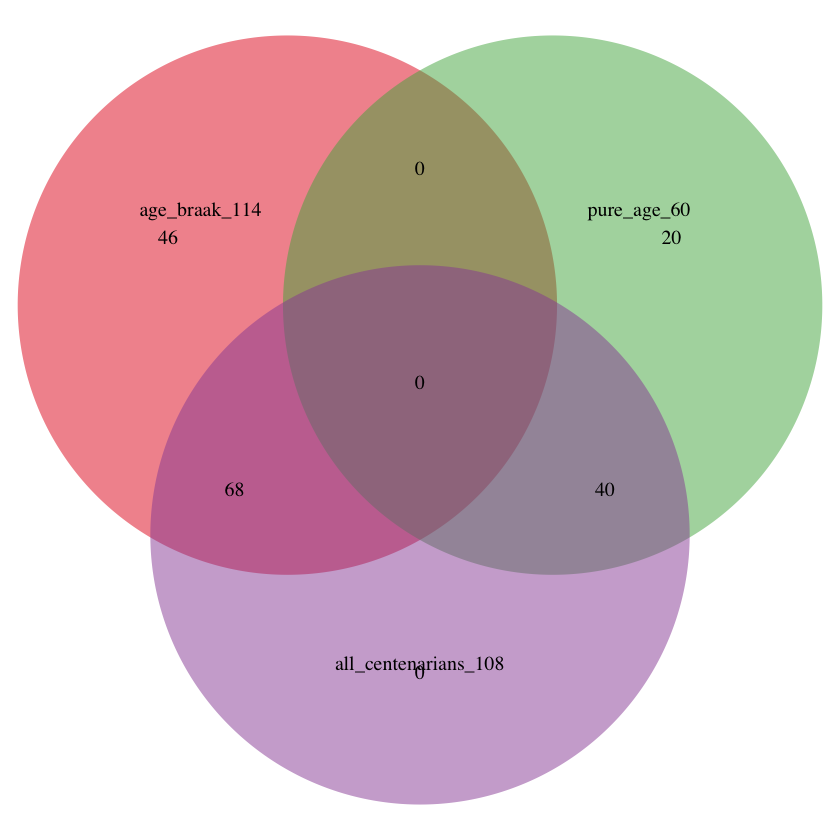

In [12]:
p <- venn.diagram(list(A=which(age_related_protein_summary$Age_Braak == "Yes"), 
                       A=which(age_related_protein_summary$Age_pure == "Yes"),
                       C=which(age_related_protein_summary$CEN_specific_ALL_centenarians == "Yes")), filename = NULL, 
                  fill=c('#E41A1C',  '#4DAF4A', '#984EA3'),
             category.names=c("age_braak_114", "pure_age_60", "all_centenarians_108"), lwd = 0, alpha = 0.5, 
                  cat.dist=c(-0.1, -0.1, -0.1),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

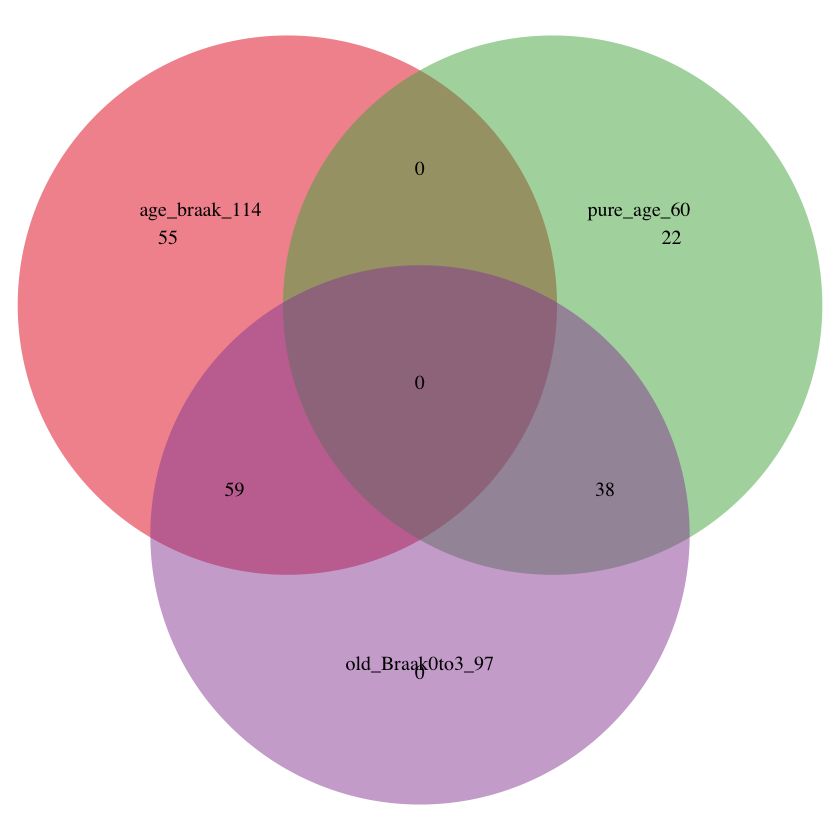

In [16]:
p <- venn.diagram(list(A=which(age_related_protein_summary$Age_Braak == "Yes"), 
                       A=which(age_related_protein_summary$Age_pure == "Yes"),
                       C=which(age_related_protein_summary$CEN_specific_Braak1to3_old == "Yes")), filename = NULL, 
                  fill=c('#E41A1C',  '#4DAF4A', '#984EA3'),
             category.names=c("age_braak_114", "pure_age_60", "old_Braak0to3_97"), lwd = 0, alpha = 0.5, 
                  cat.dist=c(-0.1, -0.1, -0.1),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

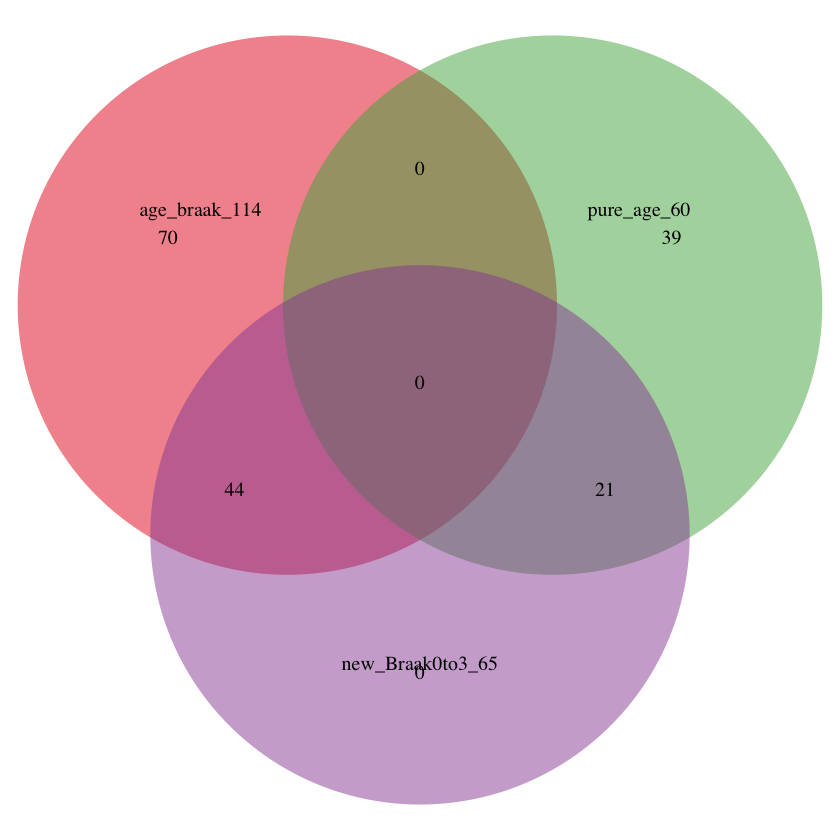

In [15]:
p <- venn.diagram(list(A=which(age_related_protein_summary$Age_Braak == "Yes"), 
                       A=which(age_related_protein_summary$Age_pure == "Yes"),
                       C=which(age_related_protein_summary$CEN_specific_Braak1to3_new == "Yes")), filename = NULL, 
                  fill=c('#E41A1C',  '#4DAF4A', '#984EA3'),
             category.names=c("age_braak_114", "pure_age_60", "new_Braak0to3_65"), lwd = 0, alpha = 0.5, 
                  cat.dist=c(-0.1, -0.1, -0.1),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

In [1]:
p <- venn.diagram(list(A=CEN_ND_idx_new, E=CEN_ND_idx_AllBraak, 
                       C=CEN_ND_idx, D=CEN_ND_idx_old_allbraak), filename = NULL, 
                  fill=c('#E41A1C',  '#4DAF4A', '#984EA3', '#FF7F00'),
             category.names=c("new_65", "old_97", "old_108", "new_108"), lwd = 0, alpha = 0.5, 
                  cat.dist=c(-0.1, -0.1, -0.1, -0.1),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

ERROR: Error in venn.diagram(list(A = CEN_ND_idx_new, E = CEN_ND_idx_AllBraak, : could not find function "venn.diagram"


In [73]:
age_protect_idx_in174 <- order(aging_protective_test$FDR)[1:length(which(aging_protective_test$FDR < 0.05))]

In [75]:
aging_protective_test[age_protect_idx_in174, ]$protein

[1] PON2                               CAND1;CAND2                       
 [3] NCDN                               CDK1                              
 [5] TUBB                               ABLIM1                            
 [7] MCAM                               PTK2B                             
 [9] CSNK2A1;CSNK2A3                    CCT6B                             
[11] AK3                                ITGB4                             
[13] TPD52L1                            CIT                               
[15] PNCK                               SNX5                              
[17] NAP1L1                             SSB                               
[19] RAP1A;RAP1B                        CCT6A                             
[21] NCKAP1;NCKAP1L                     PIP4K2A;PIP4K2B                   
[23] NDUFAF4                            H1FX                              
[25] RIMBP2                             CACNA1E                           
[27] IGSF21                             ANXA11                            
[29] CCT6A;CCT6B                        GLTP                              
[31] C2;CFB                             TUBB4A                            
[33] CHMP1A                             CNTN1                             
[35] OGFRL1                             SCN2A                             
[37] LZTS1                              PLEKHB1                           
[39] NUMA1                              MAP1A;MAP1B                       
[41] GGA3                               ILF2                              
[43] CARNS1                             MAP3K5                            
[45] LGALS3BP                           RUFY3                             
[47] CCT3                               SYPL1                             
[49] PDPK1;PDPK2P                       IRGQ                              
[51] RALA                               CHMP4B                            
[53] PTGES2                             FAM169A                           
[55] WRN                                SHMT2                             
[57] AMPD2                              MAP1B                             
[59] TUBB3;TUBB4A;TUBB4B                ENPP6                             
[61] SNX9                               RPS6KA2                           
[63] RHOG                               TUBB4A;TUBB4B;TUBB8               
[65] CD9                                RAB11A;RAB11B                     
[67] CNP                                RRAGC;RRAGD                       
[69] DNAJB1;DNAJB4                      STX5                              
[71] USP11                              ANLN                              
[73] WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 PDIA6                             
[75] PDE1A;PDE1C                        RPS13                             
[77] RPS6KA2;RPS6KA3                    MOG                               
[79] UBAP2L                             RPL31                             
[81] PIGK                               HADHA                             
[83] DYNC1I1                            NEFL                              
[85] PSD3                               PCSK1                             
[87] SHANK2                             SIRT2                             
[89] NEFM                               TMEM30A                           
[91] PNMA8B                             MAG                               
[93] USP7                               SLC44A1                           
[95] INA                                ELAVL2                            
[97] GSTK1                             
174 Levels: ABLIM1 ADAM23 AK3 ALCAM AMPD2 AMPH ANK3 ANLN ANXA11 ANXA6 ... WRN

In [43]:
age_protect_idx <- lm_index[order(aging_protective_test$FDR)[1:length(which(aging_protective_test$FDR < 0.05))]]

In [44]:
length(age_protect_idx)

[1] 97

In [80]:
write.table(aging_protective_test[age_protect_idx_in174, ][, c(1, 7, 4, 5)], 
            "100_plus_results/Age_related_protein/Centenarian_specific_age_related_proteins.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [142]:
age_pure_idx <- setdiff(age_protect_idx, age_Braak_sig_idx)

In [143]:
age_Braak_idx <- setdiff(age_protect_idx, pure_sig_age_index)

In [144]:
length(age_pure_idx)
length(age_Braak_idx)

[1] 38

[1] 59

In [65]:
Age_related_proteins[age_protect_idx, ]

,protein,uniprot_accessions,gene,HUGO_gene,slope,p.value,FDR
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2260,PON2,J3QT77;Q15165-3;A0A0J9YYG4;Q15165-1;Q15165;A0A0J9YXF2;G3XAK4,PON2,PON2,-0.021270668,1.426375e-05,4.918139e-02
3057,CAND1;CAND2,Q86VP6;Q86VP6-2;A0A0C4DGH5;O75155;O75155-2,CAND1,CAND1,-0.011316704,1.877166e-06,6.472468e-03
703,NCDN,Q9UBB6;Q9UBB6-3;Q9UBB6-2,NCDN,NCDN,0.007506020,3.319534e-07,1.144575e-03
2062,CDK1,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,CDK1,CDK1,-0.011084598,4.068028e-06,1.402656e-02
795,TUBB,Q5JP53;P07437;Q5ST81,TUBB,TUBB,-0.004409366,1.130163e-07,3.896801e-04
1842,ABLIM1,O14639-2;O14639-6;O14639;F8W8M4;A0A0A0MRL6,ABLIM1,ABLIM1,0.014137553,8.864796e-12,3.056582e-08
1864,MCAM,P43121;P43121-2,MCAM,MCAM,-0.020315308,4.436843e-06,1.529823e-02
1531,PTK2B,Q14289-2;Q14289,PTK2B,PTK2B,0.008040285,3.622518e-09,1.249044e-05
1888,CSNK2A1;CSNK2A3,E7EU96;P68400;Q8NEV1;P68400-2,CSNK2A1,CSNK2A1,-0.004144560,4.452080e-11,1.535077e-07


In [153]:
pure_aging_protective_protein <- cell_type_matrix[age_Braak_idx, ]

In [154]:
pure_aging_protective_protein$p.vale <- Age_related_proteins_lm[age_Braak_idx, ]$p_value
pure_aging_protective_protein$adj.lm.p <- Age_related_proteins_lm[age_Braak_idx, ]$adjusted_p_value
pure_aging_protective_protein$slope <- Age_related_proteins_lm[age_Braak_idx, ]$effect_size

In [155]:
pure_aging_protective_protein

,protein,genesymbol,HUGO_gene,celltype,p.vale,adj.lm.p,slope
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2340,PON2,PON2,PON2,NA,1.426375e-05,4.918139e-02,-0.021270668
819,TUBB,TUBB,TUBB,NA,1.130163e-07,3.896801e-04,-0.004409366
1903,ABLIM1,ABLIM1,ABLIM1,NA,8.864796e-12,3.056582e-08,0.014137553
1926,MCAM,MCAM,MCAM,Oligodendrocytes,4.436843e-06,1.529823e-02,-0.020315308
1575,PTK2B,PTK2B,PTK2B,NA,3.622518e-09,1.249044e-05,0.008040285
1950,CSNK2A1;CSNK2A3,CSNK2A1,CSNK2A1,NA,4.452080e-11,1.535077e-07,-0.004144560
2694,CCT6B,CCT6B,CCT6B,NA,2.554607e-07,8.808284e-04,-0.003324397
1198,AK3,AK3,AK3,NA,9.276217e-06,3.198440e-02,-0.017769943
3164,ITGB4,ITGB4,ITGB4,Astrocytes,1.419307e-05,4.893771e-02,0.015578798


In [134]:
aging_protective_protein$regulation <- sapply(aging_protective_protein$effect_size, function(x){
    if(x < 0)
        return("Down")
    else
        return("Up")
})

In [135]:
write.table(pure_aging_protective_protein, 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [57]:
write.table(aging_protective_protein[aging_protective_protein$regulation == "Down", ], 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean_Down.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [156]:
write.table(pure_aging_protective_protein, 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean_59.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [183]:
PRS_data <- read_excel("100_plus_project/PRS_and_genotypes_ADsnps_100plus.xlsx",
                       sheet=1,col_names=TRUE, na="NA")

In [184]:
ID_map <- read.table("100_plus_project/Metadata/Centenarian_ID_map.tsv", 
                     sep = "\t", header =TRUE, stringsAsFactors=F)

In [185]:
metadata$ID <- as.character(lapply(metadata$nbb, function(x){
    if (x %in% ID_map$NBB){
        return(ID_map[which(ID_map$NBB == x), ]$ID)
    }
    else{
        return(NA)
    }
}))

In [186]:
metadata$PRS <- as.numeric(lapply(metadata$ID, function(x, label){
    if (is.na(x)){
        return(NA)
    }
    else{
        return(PRS_data[which(PRS_data$ID_100plus == x), ][[label]])
    }
}, "PRS_41snps_noAPOE_BetaIGAP"))

In [265]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,apoe_OR,pmd_numeric,MMSE,Abeta,age_level,MMSE_level
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,A,23,20190325_121_S16_020_CHC_011,2,1,0.6,6.166667,21.00,1,3,1
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,C,33,20190325_125_S16_044_CHC_007,3,2,1.0,5.283333,26.37,3,3,2
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,A,33,20190325_127_S16_094_CHC_004,3,2,1.0,7.916667,26.78,1,3,2
16,2004-011,04/037,F,84,1017,AD,05:55,5,C,33,20190325_16_04_037_AD_008,5,3,1.0,5.916667,NA,3,2,NA
182,2010-101,S10/292,M,64,1233,AD,04:35,6,C,32,20190325_183_S10_292_AD_010,6,3,0.6,4.583333,NA,3,1,NA
193,2002-024,S02/055,F,75,1153,ND,05:30,1,C,42,20190325_194_S02_055_ND_005,1,1,2.6,5.500000,NA,3,1,NA
31,2001-081,01/184,F,93,1010,AD,05:05,5,C,33,20190325_31_01_184_AD_006,5,3,1.0,5.083333,NA,3,2,NA
57,1997-091,S97/235,F,85,1000,AD,02:00,5,C,43,20190325_57_S97_235_AD_003,5,3,3.2,2.000000,NA,3,2,NA
77,2011-072,S11/072,F,76,1072,ND,07:15,2,O,33,20190325_77_S11_072_ND_012,2,1,1.0,7.250000,NA,0,1,NA


In [188]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            sex = as.character(metadata$sex),
                            PRS = as.numeric(metadata$PRS),
                            group = as.character(metadata$GROUP),
                            Braak = as.factor(metadata$fBraak),
                            intensity = as.numeric(protein_intensity_combat[index,]))
        
    temp_prot <- subset(temp_prot, group != "AD")
    
    res = cor.test(formula = ~PRS+intensity, data = subset(temp_prot, group == "CHC"), method = "spearman")
    #print(res)
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity))+
        geom_point(color = color_ND, size = 0.5) +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != "ND"), size = 0.5,
                   mapping = aes(x = age, y = intensity, col = PRS), alpha = 0.7) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        annotate("label", x = -Inf, y = Inf, vjust = 1, hjust = 0, size = 5,
                 label = paste("p = ", round(res$p.value, 3), "\n", 
                               "r  = ", round(res$estimate, 3), sep = "")) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
        
        scale_color_viridis(option = "D", direction = -1) +
        #scale_colour_gradient(low = "seagreen1", high = "red", na.value = NA)
    
        theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
              #panel.border = element_rect(),       # Border around plotting area.      
              #panel.grid = element_line(),         # All grid lines
              #panel.grid.major = element_line(),   # Major grid lines
              #panel.grid.minor = element_line(),   # Minor grid lines
      
              panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Vertical major grid lines
              panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Horizontal major grid lines
              panel.grid.minor.x = element_line(), # Vertical minor grid lines
              panel.grid.minor.y = element_line(),  # Vertical major grid lines
              
              legend.position = "bottom",
            
              plot.title = element_text(hjust = 0.5),
              axis.title.x = element_text(color = "black", size = 12),
              axis.title.y = element_text(color = "black", size = 12),
              
              axis.text.x = element_text(size = 12, color = "black", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 12, color = "black"),
              
              axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
             )
    return(p)
    
}

In [189]:
aging_protective_plots <- NULL
legend <- NULL

for(i in 1:length(age_protect_idx)){
    p <- plot_protective_proteins_aging(age_protect_idx[i])
    legend <- get_legend(p)
    aging_protective_plots[[i]] <- p + theme(legend.position = "none")
}

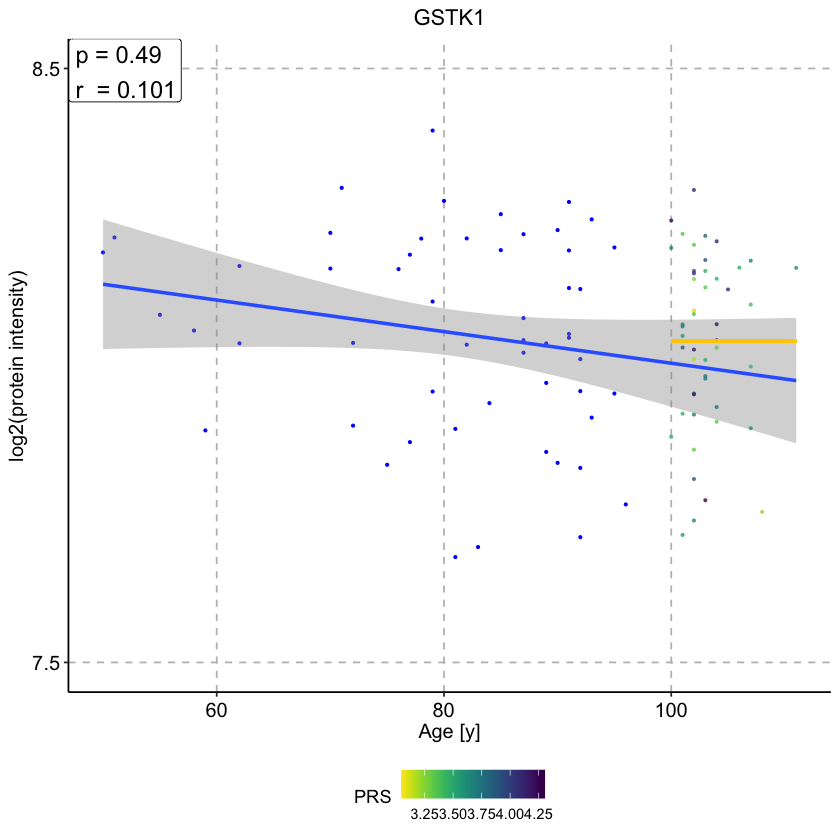

In [190]:
p

In [191]:
p <- plot_grid(plotlist = aging_protective_plots, align = "hv", axis = "lrtb", ncol = 3)

p_CEN <- plot_grid(legend, p, align = "v", axis = "lr", rel_heights = c(0.005, 0.995), nrow = 2)

save_plot("100_plus_plots/proteomics/Cen_specific_aging_protein_97_PRS_41snps_noAPOE_BetaIGAP.jpg", p_CEN, 
          limitsize = FALSE,
          base_height = 100, base_width = 10)

In [244]:
raw_metadata <- as.data.frame(read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData.xlsx",
                               sheet=1,col_names=TRUE, na="NA"))

In [247]:
metadata_clean <- raw_metadata[, c("ID", "NBB", "Sex", "Age_death")]

In [248]:
metadata_clean$key_search_raw_score <- raw_metadata$Keysearch_LAST_AVAILABLE
metadata_clean$number_loc <- as.numeric(raw_metadata$NumberLoc_LAST_AVAILABLE)
metadata_clean$rbmt_reproduction_v2 <- raw_metadata$ImmediateRecall_LAST_AVAILABLE
metadata_clean$rbmt_recall_v2 <- raw_metadata$DelayedRecall_LAST_AVAILABLE
metadata_clean$tmt_a_time <- raw_metadata$TMTA_LAST_AVAILABLE
metadata_clean$tmt_b_time <- raw_metadata$TMTB_LAST_AVAILABLE
metadata_clean$vat_a_trial1_and_2 <- raw_metadata$VAT_LAST_AVAILABLE
metadata_clean$clock_drawing_score_shulman <- raw_metadata$CLOCKDR_LAST_AVAILABLE
metadata_clean$forward_wais3_raw <- raw_metadata$Forward_LAST_AVAILABLE
metadata_clean$backward_wais3_raw <- as.numeric(raw_metadata$Backward_LAST_AVAILABLE)
metadata_clean$dat_fluency <- as.numeric(raw_metadata$LetterFluency_LAST_AVAILABLE)
metadata_clean$animal_fluence_twomin <- raw_metadata$AnimalFluency_LAST_AVAILABLE

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [249]:
metadata_clean$TMTA_reversed <- 1-as.numeric((raw_metadata$TMTA_LAST_AVAILABLE))
metadata_clean$TMTB_corrected <- 1-(1-as.numeric(raw_metadata$TMTB_LAST_AVAILABLE))/(1-as.numeric(raw_metadata$TMTA_LAST_AVAILABLE))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [250]:
#Global cognition
metadata_clean$zMMSE <- ((raw_metadata$MMSE_LAST_AVAILABLE-mean(raw_metadata$MMSE_BSL, na.rm=T))
             /sd(raw_metadata$MMSE_BSL, na.rm=T))

In [251]:
#Memory
metadata_clean$zRBMT_immediate_recall <- ((raw_metadata$ImmediateRecall_LAST_AVAILABLE-
                                           mean(raw_metadata$ImmediateRecall_BSL, na.rm=T))/sd(raw_metadata$ImmediateRecall_BSL, na.rm=T))

metadata_clean$zRBMT_delayed_recall <- ((raw_metadata$DelayedRecall_LAST_AVAILABLE-
                                         mean(raw_metadata$DelayedRecall_BSL, na.rm=T))/sd(raw_metadata$DelayedRecall_BSL, na.rm=T))

metadata_clean$zVAT <- ((raw_metadata$VAT_LAST_AVAILABLE-
                         mean(raw_metadata$VAT_BSL, na.rm=T))/sd(raw_metadata$VAT_BSL, na.rm=T))

metadata_clean$sum_Memory <- rowSums(metadata_clean[c("zVAT", "zRBMT_delayed_recall", "zRBMT_immediate_recall")], na.rm=T)

metadata_clean$count_Memory <-3-(rowSums(is.na(metadata_clean[c("zVAT", "zRBMT_delayed_recall", "zRBMT_immediate_recall")])))
 
metadata_clean$zMemory <- metadata_clean$sum_Memory/metadata_clean$count_Memory

In [252]:
#Fluency
 
metadata_clean$zAnimal_fluency <- ((raw_metadata$AnimalFluency_LAST_AVAILABLE-
                                    mean(raw_metadata$AnimalFluency_BSL, na.rm=T))/
                                    sd(raw_metadata$AnimalFluency_BSL, na.rm=T)) 
metadata_clean$zLetter_fluency <- ((as.numeric(raw_metadata$LetterFluency_LAST_AVAILABLE)-
                                    mean(as.numeric(raw_metadata$LetterFluency_BSL), na.rm=T))/
                                    sd(as.numeric(raw_metadata$LetterFluency_BSL), na.rm=T))
 
metadata_clean$sum_Fluency <- rowSums(metadata_clean[c("zAnimal_fluency", "zLetter_fluency")], na.rm=T)

metadata_clean$count_Fluency <-2-(rowSums(is.na(metadata_clean[c("zAnimal_fluency", "zLetter_fluency")])))

metadata_clean$zFluency <-metadata_clean$sum_Fluency/metadata_clean$count_Fluency

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [253]:
#Executive functioning
metadata_clean$TMTB_corrected <- 1-(1-as.numeric(raw_metadata$TMTB_LAST_AVAILABLE))/(1-as.numeric(raw_metadata$TMTA_LAST_AVAILABLE))
TMTB_corrected_BSL <- 1-(1-raw_metadata$TMTB_BSL)/(1-raw_metadata$TMTA_BSL)
 
metadata_clean$zTMTB_corrected <-((metadata_clean$TMTB_corrected-mean(TMTB_corrected_BSL, na.rm=T))/
                      sd(TMTB_corrected_BSL, na.rm=T))
 
metadata_clean$zKey_search <-((raw_metadata$Keysearch_LAST_AVAILABLE-
                               mean(raw_metadata$Keysearch_BSL, na.rm=T))/
                               sd(raw_metadata$Keysearch_BSL, na.rm=T))
 
metadata_clean$zDS_bw <-((as.numeric(raw_metadata$Backward_LAST_AVAILABLE)-
                          mean(as.numeric(raw_metadata$Backward_BSL), na.rm=T))/
                          sd(as.numeric(raw_metadata$Backward_BSL), na.rm=T))
 
metadata_clean$sum_EF <-  rowSums(metadata_clean[c("zTMTB_corrected", "zKey_search", "zDS_bw")], na.rm=T)
 
metadata_clean$count_EF <- 3-(rowSums(is.na(metadata_clean[c("zTMTB_corrected", "zKey_search", "zDS_bw")])))
 
metadata_clean$zEF <- metadata_clean$sum_EF/metadata_clean$count_EF

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [254]:
#Visuospatial functioning
 
metadata_clean$zClock <- ((raw_metadata$CLOCKDR_LAST_AVAILABLE-
                           mean(raw_metadata$CLOCKDR_BSL, na.rm=T))/
                           sd(raw_metadata$CLOCKDR_BSL, na.rm=T))
 
metadata_clean$zNumber_location <- ((as.numeric(raw_metadata$NumberLoc_LAST_AVAILABLE)-
                                     mean(as.numeric(raw_metadata$NumberLoc_BSL), na.rm=T))/
                                     sd(as.numeric(raw_metadata$NumberLoc_BSL), na.rm=T))
 
metadata_clean$sum_spatial <- rowSums(metadata_clean[c("zClock", "zNumber_location")], na.rm=T)
 
metadata_clean$count_spatial <- 2-(rowSums(is.na(metadata_clean[c("zClock", "zNumber_location")])))
 
metadata_clean$zSpatial <- metadata_clean$sum_spatial/metadata_clean$count_spatial

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [255]:
#Processing speed and attention
 
metadata_clean$TMTA_new <-1-as.numeric((raw_metadata$TMTA_LAST_AVAILABLE))
TMTA_new_BSL <- 1-as.numeric((raw_metadata$TMTA_BSL))

metadata_clean$zTMTA <-((metadata_clean$TMTA_new-
                         mean(TMTA_new_BSL, na.rm=T))/sd(TMTA_new_BSL, na.rm=T))
 
metadata_clean$zDS_fw <-((raw_metadata$Forward_LAST_AVAILABLE-
                          mean(raw_metadata$Forward_BSL, na.rm=T))/
                          sd(raw_metadata$Forward_BSL, na.rm=T))
 
metadata_clean$sum_attention <- rowSums(metadata_clean[c("zTMTA", "zDS_fw")], na.rm=T)
 
metadata_clean$count_attention <- 2-(rowSums(is.na(metadata_clean[c("zTMTA", "zDS_fw")])))
 
metadata_clean$zAttention <- metadata_clean$sum_attention/metadata_clean$count_attention

In [258]:
for(i in 1:nrow(metadata_clean)){
    for (j in 1:ncol(metadata_clean)){
        if (is.nan(metadata_clean[i, ][, j])){
            metadata_clean[i, ][j] <- NA
        }
    }
}

In [315]:
metadata$perf <- as.numeric(lapply(metadata$nbb, function(x, label){
    if (is.na(x)){
        return(NA)
    }
    else{
        return(metadata_clean[which(metadata_clean$NBB == x), ][[label]])
    }
}, "zAttention"))

In [316]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,apoe_OR,pmd_numeric,MMSE,Abeta,age_level,MMSE_level,perf
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,A,23,20190325_121_S16_020_CHC_011,2,1,0.6,6.166667,21.00,1,3,1,-0.1845676
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,C,33,20190325_125_S16_044_CHC_007,3,2,1.0,5.283333,26.37,3,3,2,-1.1626925
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,A,33,20190325_127_S16_094_CHC_004,3,2,1.0,7.916667,26.78,1,3,2,0.3368548
16,2004-011,04/037,F,84,1017,AD,05:55,5,C,33,20190325_16_04_037_AD_008,5,3,1.0,5.916667,NA,3,2,NA,NA
182,2010-101,S10/292,M,64,1233,AD,04:35,6,C,32,20190325_183_S10_292_AD_010,6,3,0.6,4.583333,NA,3,1,NA,NA
193,2002-024,S02/055,F,75,1153,ND,05:30,1,C,42,20190325_194_S02_055_ND_005,1,1,2.6,5.500000,NA,3,1,NA,NA
31,2001-081,01/184,F,93,1010,AD,05:05,5,C,33,20190325_31_01_184_AD_006,5,3,1.0,5.083333,NA,3,2,NA,NA
57,1997-091,S97/235,F,85,1000,AD,02:00,5,C,43,20190325_57_S97_235_AD_003,5,3,3.2,2.000000,NA,3,2,NA,NA
77,2011-072,S11/072,F,76,1072,ND,07:15,2,O,33,20190325_77_S11_072_ND_012,2,1,1.0,7.250000,NA,0,1,NA,NA


In [317]:
plot_protective_proteins_aging <- function(index, legend_name){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            sex = as.character(metadata$sex),
                            Performance = as.numeric(metadata$perf),
                            group = as.character(metadata$GROUP),
                            Braak = as.factor(metadata$fBraak),
                            intensity = as.numeric(protein_intensity_combat[index,]))
        
    temp_prot <- subset(temp_prot, group != "AD")
    
    res = cor.test(formula = ~Performance+intensity, 
                   data = subset(temp_prot, group == "CHC"), exact = FALSE,
                   method = "spearman")
    #print(subset(temp_prot, group == "CHC"))
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity))+
        geom_point(color = color_ND, size = 0.5) +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != "ND"), size = 0.5,
                   mapping = aes(x = age, y = intensity, col = Performance), alpha = 0.7) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        annotate("label", x = -Inf, y = Inf, vjust = 1, hjust = 0, size = 5,
                 label = paste("p = ", round(res$p.value, 3), "\n", 
                               "r  = ", round(res$estimate, 3), sep = "")) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
        
        scale_color_viridis(name = legend_name, option = "D", direction = -1) +
        #scale_colour_gradient(low = "seagreen1", high = "red", na.value = NA)
    
        theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
              #panel.border = element_rect(),       # Border around plotting area.      
              #panel.grid = element_line(),         # All grid lines
              #panel.grid.major = element_line(),   # Major grid lines
              #panel.grid.minor = element_line(),   # Minor grid lines
      
              panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Vertical major grid lines
              panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Horizontal major grid lines
              panel.grid.minor.x = element_line(), # Vertical minor grid lines
              panel.grid.minor.y = element_line(),  # Vertical major grid lines
              
              legend.position = "bottom",
            
              plot.title = element_text(hjust = 0.5),
              axis.title.x = element_text(color = "black", size = 12),
              axis.title.y = element_text(color = "black", size = 12),
              
              axis.text.x = element_text(size = 12, color = "black", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 12, color = "black"),
              
              axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
             )
    return(p)
    
}

In [318]:
aging_protective_plots <- NULL
legend <- NULL

for(i in 1:length(age_protect_idx)){
    p <- plot_protective_proteins_aging(age_protect_idx[i], "Attention")
    legend <- get_legend(p)
    aging_protective_plots[[i]] <- p + theme(legend.position = "none")
}

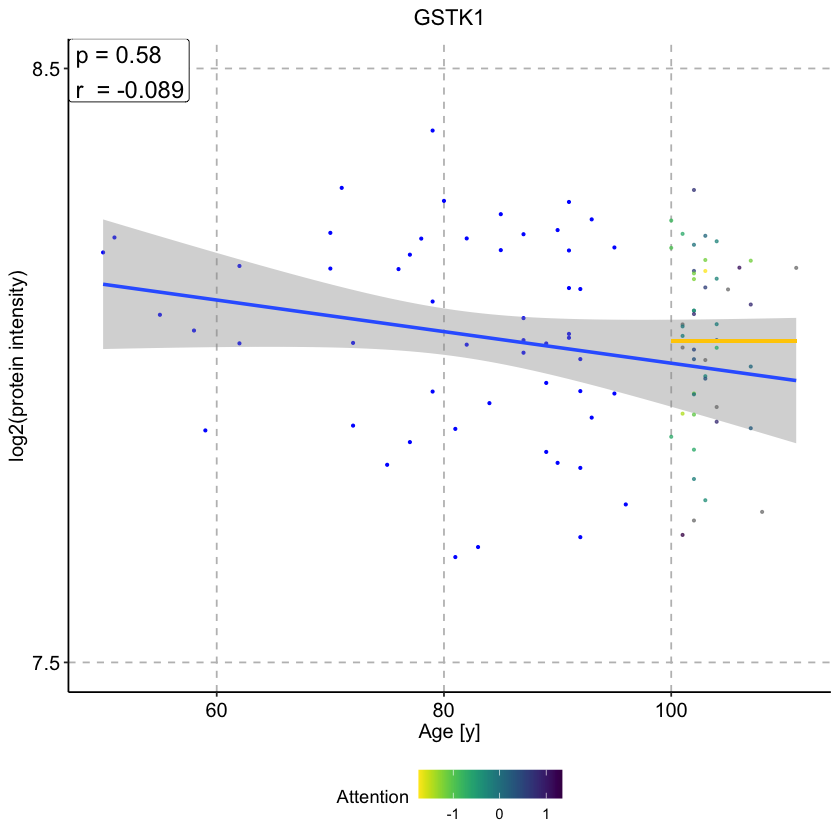

In [319]:
p

In [320]:
p <- plot_grid(plotlist = aging_protective_plots, align = "hv", axis = "lrtb", ncol = 3)

p_CEN <- plot_grid(legend, p, align = "v", axis = "lr", rel_heights = c(0.005, 0.995), nrow = 2)

save_plot("100_plus_plots/proteomics/Cen_specific_aging_protein_97_Attention.jpg", p_CEN, 
          limitsize = FALSE,
          base_height = 100, base_width = 10)

In [281]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    #print(length(which((temp_prot$age >= 80)&(temp_prot$intensity < 6.5)&(temp_prot$group == "ND"))))
    temp_prot <- subset(temp_prot, group != "AD")
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.1
    y_end <- round(max(temp_prot$intensity)) + 0.1
    
    #y_start <- 6
    #y_end <- 16
    
    #if(y_start == y_end)
    #    y_end = y_end + 1
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity, col = group))+
        geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != "ND"), mapping = aes(x = age, y = intensity, col = group)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(breaks=seq(y_start, y_end, 0.2)) +
    
        scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC),
                           labels = c(paste("Non-dementia (n=", 
                                            length(which(temp_prot$group == "ND")), ")", sep = ''),
                                      paste("Alzheimer's (n=", 
                                            length(which(temp_prot$group == "AD")), ")", sep = ''),
                                      paste("Centenarian (n=", 
                                            length(which(temp_prot$group == "CHC")), ")", sep = '')),
                           guide = guide_legend(override.aes = list(alpha = 1, linetype = c("solid", "solid")))
                          )+
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
          #legend.position = "bottom",
          legend.position = "bottom",
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
    
}

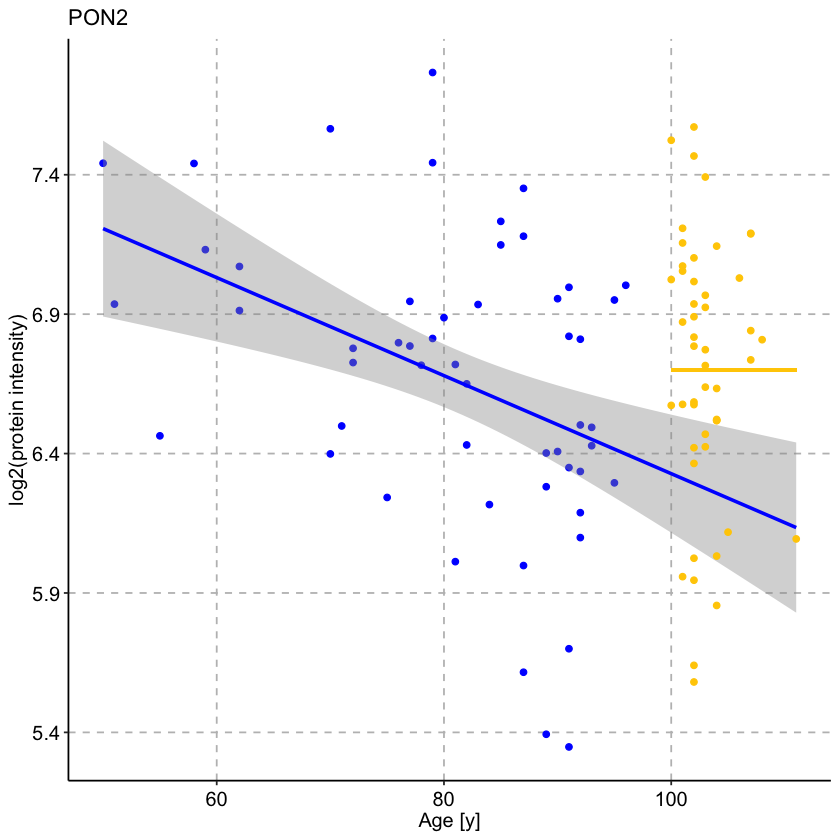

In [278]:
PON2_plot <- plot_protective_proteins_aging(age_protect_idx[1])
PON2_plot

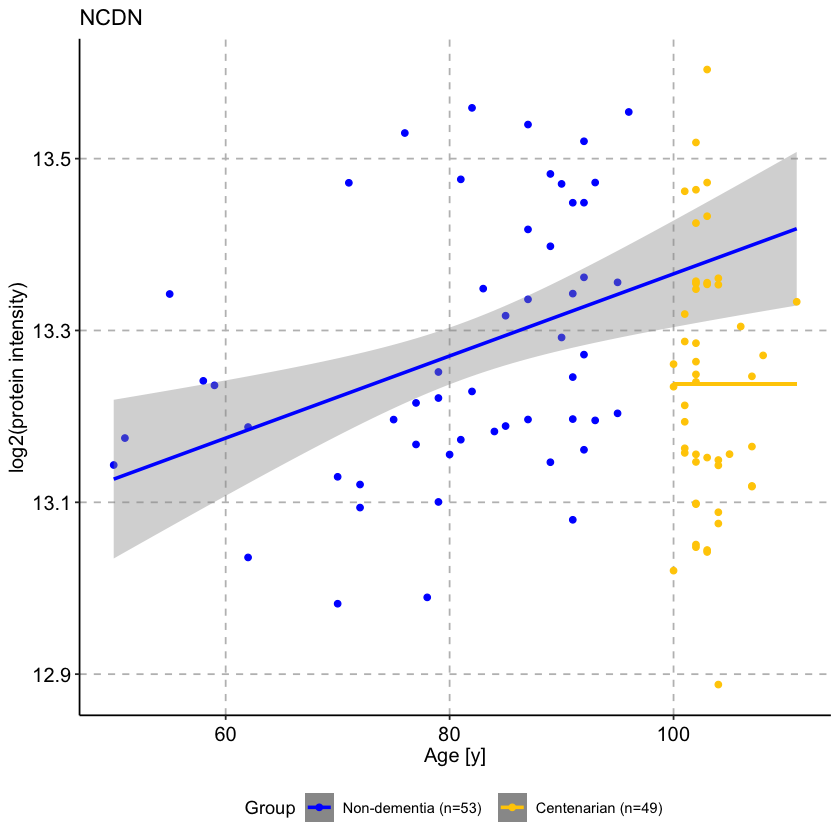

In [282]:
NCDN_plot <- plot_protective_proteins_aging(age_protect_idx[3])
NCDN_plot

In [301]:
p <- plot_grid(PON2_plot, NCDN_plot, 
               align = "v", axis = "lrtb", labels = c("A", "B"), 
               label_size = 12, hjust = -1, vjust=1.7, rel_heights = c(0.48, 0.52),
               nrow = 2, ncol = 1)

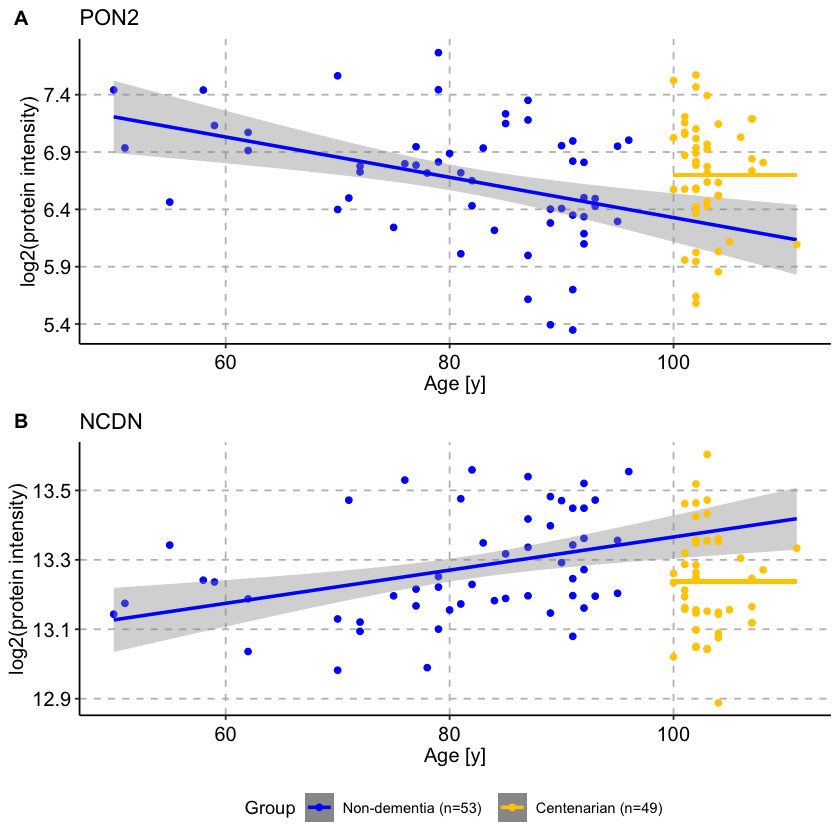

In [302]:
p

In [303]:
save_plot("100_plus_plots/proteomics/Cen specific proteins 2sample.jpg", 
          p, base_height = 8, base_width = 6)

In [60]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    #print(length(which((temp_prot$age >= 80)&(temp_prot$intensity < 6.5)&(temp_prot$group == "ND"))))
    
    temp_prot <- subset(temp_prot, group != "AD")
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    #y_start <- 6
    #y_end <- 16
    
    #if(y_start == y_end)
    #    y_end = y_end + 1
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity, col = group))+
        geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != "ND"), mapping = aes(x = age, y = intensity, col = group)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
    
        scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC),
                           guide = guide_legend(override.aes = list(alpha = 1, linetype = c("solid", "solid")))
                          )+
    
        
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
    
}

In [61]:
aging_protective_plots <- NULL

In [62]:
for(i in 1:length(extra_proteins)){
    p  <- plot_protective_proteins_aging(extra_proteins[i])
    aging_protective_plots[[i]] <- p
}

In [64]:
p <- plot_grid(plotlist = aging_protective_plots[1:33], ncol = 3)
save_plot("100_plus_plots/proteomics/age_protective_protein_extra_33.pdf", p, base_height = 40, base_width = 15)

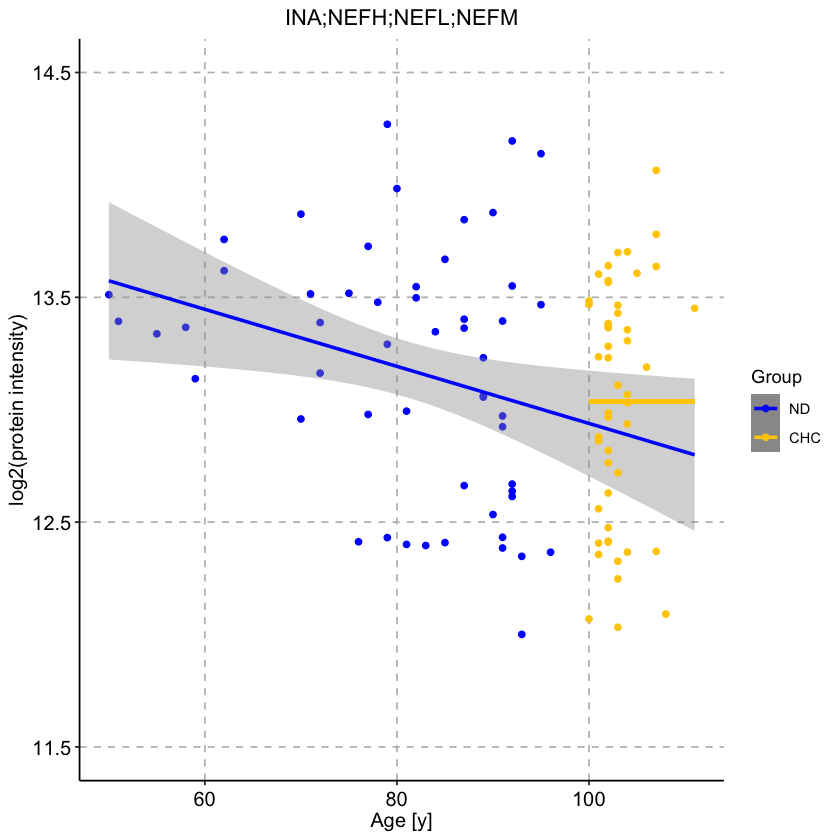

In [265]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "INA;NEFH;NEFL;NEFM"))

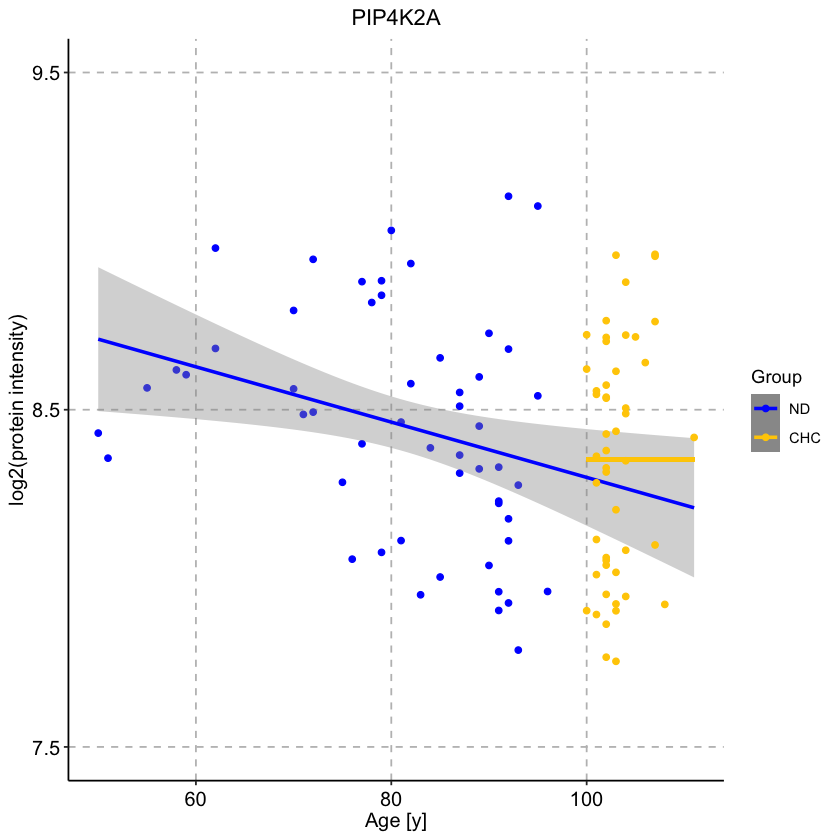

In [266]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "PIP4K2A"))

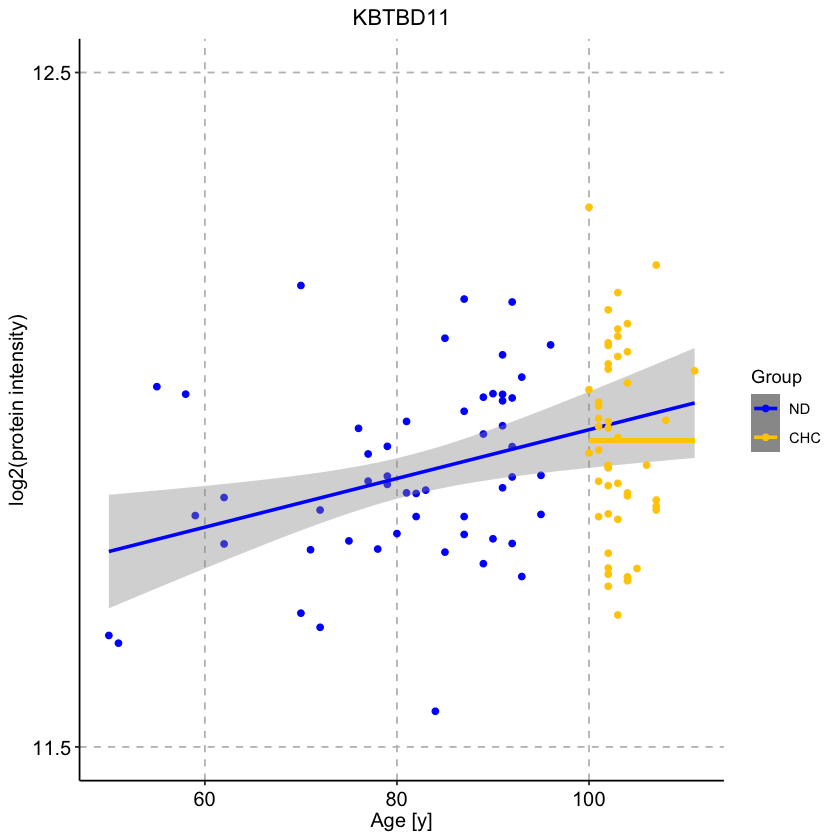

In [267]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "KBTBD11"))

In [95]:
MMSE_data <- read_excel("100_plus_project/20190513_dataExtraction.xlsx",sheet=1,col_names=TRUE, na="NA")
#MMSE_data
MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
nrow(MMSE_data)

metadata$MMSE <- rep(NA, nrow(metadata))

for (i in 1:nrow(metadata)){
    if (metadata[i,]$GROUP == "CHC"){
        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
    }
}

[1] 65

In [96]:
metadata$MMSE <- as.numeric(metadata$MMSE)

In [97]:
metadata$group <- metadata$GROUP

In [98]:
metadata[which(metadata$MMSE >= 26), ]$group <- "CHC_H"
metadata[which((metadata$MMSE < 26) & (metadata$MMSE > 22)),]$group <- "CHC_M"
metadata[which(metadata$MMSE <= 22), ]$group <- "CHC_L"

In [112]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            Sex = as.character(metadata$sex),
                            group = as.character(metadata$group),
                            label = as.character(metadata$GROUP),
                            Braak = as.factor(metadata$fBraak),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    
    
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC", "CHC_H", "CHC_M", "CHC_L"))
    
    temp_prot <- subset(temp_prot, group != "AD")
    
    #temp_prot$alpha <- 1
    #temp_prot[which(temp_prot$group %in% c("CHC", "CHC_M", "CHC_L")), ]$alpha <- 1
    
    CHC_mean <- mean(temp_prot[which(temp_prot$label == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$label == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$label == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity))+
        #geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != ""), 
                   mapping = aes(x = age, y = intensity, col = Braak)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
    
        #scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC", "CHC_H", "CHC_M", "CHC_L"), 
        #               values = c(color_ND, color_AD, color_CHC, '#E41A1C', '#4DAF4A', '#377EB8'),
        #               guide = guide_legend(override.aes = list(alpha = 1, 
        #                                                        linetype = c("blank", 
        #                                                                     "blank", "blank", "blank")))
        #              )+
    
    
        scale_color_manual(name="Braak", breaks = 1:6, 
                       values = c('#377EB8', '#4DAF4A', '#984EA3', "#FFCC00", '#FF7F00', '#E41A1C'),
                       guide = guide_legend(override.aes = list(alpha = 1, 
                                                                linetype = c("blank", "blank",  "blank",
                                                                             "blank",  "blank")))
                      )+
    
        theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
              #panel.border = element_rect(),       # Border around plotting area.
                                                   # fill argument should be NA
      
              #panel.grid = element_line(),         # All grid lines
              #panel.grid.major = element_line(),   # Major grid lines
              #panel.grid.minor = element_line(),   # Minor grid lines
      
              panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Vertical major grid lines
              panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Horizontal major grid lines
              panel.grid.minor.x = element_line(), # Vertical minor grid lines
              panel.grid.minor.y = element_line(),  # Vertical major grid lines
            
              plot.title = element_text(hjust = 0.5),
              axis.title.x = element_text(color = "black", size = 12),
              axis.title.y = element_text(color = "black", size = 12),
              
              axis.text.x = element_text(size = 12, color = "black", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 12, color = "black"),
              
              axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
             )
    return(p)
    
}

In [113]:
aging_protective_plots <- NULL

for(i in 1:2){
p  <- plot_protective_proteins_aging(special_63_idx_2[i])
aging_protective_plots[[i]] <- p
}


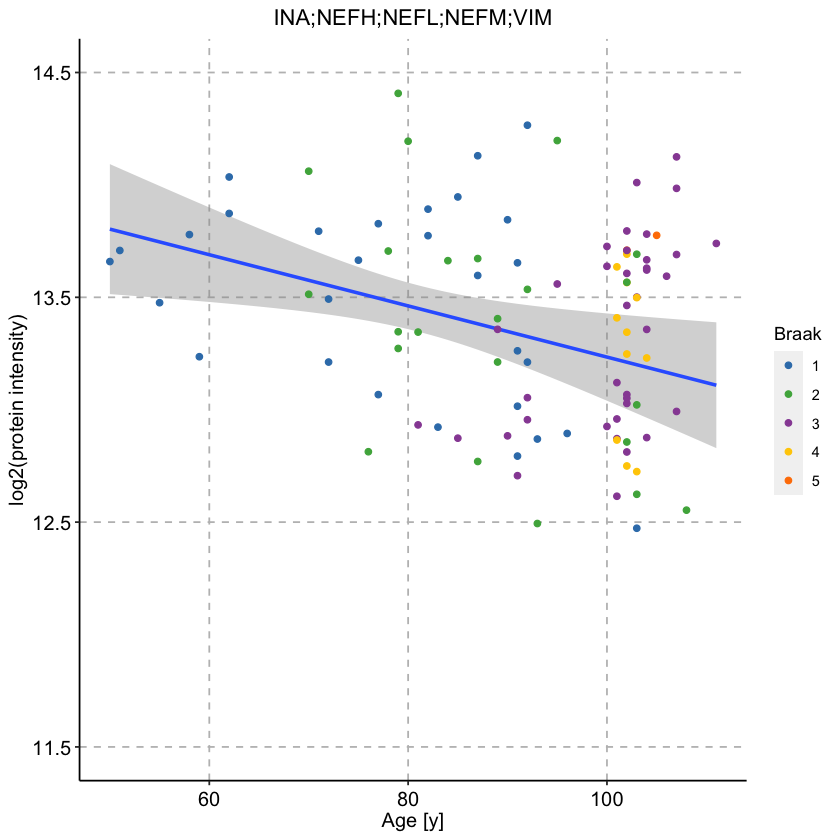

In [114]:
p

In [115]:
p <- plot_grid(plotlist = aging_protective_plots, ncol = 2)
save_plot("100_plus_plots/proteomics/Aging_protective_protein_Braak4&5_43_41_2.pdf", p, limitsize = FALSE, base_height = 5, base_width = 10)

In [202]:
d <- NULL

In [203]:
for(i in 1:1000){
    d <- c(d, ks.test(rnorm(20, mean = 0, sd = 1), rnorm(20, mean = 0, sd = 1))$statistic)
}

In [204]:
mean(d)

[1] 0.25325

In [292]:
(28.64 - 4.95 - 4.29 + 7.1 + 37.34) / 5

[1] 12.768